In [47]:
# Import moduls
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from math import nan

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import keras.losses as kl
from tensorflow.keras.callbacks import EarlyStopping

from core.classes import FeatureEngineer, DataImputation

pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [48]:
path = '../data/processed/combined_data_with_elasticity.csv'
df = pd.read_csv(path, index_col='date', skipfooter=1, parse_dates=True)


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\3118146038.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, index_col='date', skipfooter=1, parse_dates=True)


## Classes for training the models

In [ ]:
class Model(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X#
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)

        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        self.model_middle.fit( feat_middle.loc[:,['target_pred_by_1', 'Ferrero']],target_middle)

        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])

        self.model_end.fit(feat_end.loc[:,['target_pred_by_2', 'LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()
        feat_middle = feat_middle.loc[~mask_f , :]
        target_middle = y.loc[~mask_f]
        feat_middle['target_pred_by_1'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])
        result.loc[: ,'pred_m']= self.model_start.predict(X.loc[:, self.columns + ['Mondelez']])
       
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end = y.loc[~mask_f & ~mask_l]
        feat_end['target_pred_by_1'] = self.model_start.predict(feat_end.loc[:, self.columns + ['Mondelez']])
        feat_end['target_pred_by_2'] = self.model_middle.predict(feat_end.loc[:,['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[:, ['target_pred_by_1', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_end.loc[:,  ['target_pred_by_2', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.weight_mond_fer + result.loc[~mask_f & mask_l, 'pred_mf'] * self.weight_fer_fer 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.weight_mond + result.loc[~mask_l,'pred_mf'] * self.weight_fer + result.loc[~mask_l,'pred_mfl'] * self.weight_lindt
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [50]:
class Model_pred_error(TransformerMixin, BaseEstimator):
    """Imputs missing values. """
    
    def __init__(self,columns, model_start, model_middle, model_end): 
        """Initalizes the attributes."""
        self.features = []
        self.num_cols = []
        self.dict_num = {}
        self.model_start = model_start
        self.model_middle = model_middle 
        self.model_end = model_end
        self.columns = columns
        self.weight_mond = 0
        self.weight_fer = 0
        self.weight_mond_fer = 0
        self.weight_fer_fer = 0
        self.weight_lindt = 0
        self.eta = 0.9

    def fit(self, X, y=None):
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()
        number_mond = (~X['Mondelez'].isna()).sum()
        number_fer = (~X['Ferrero'].isna()).sum()
        number_lindt = (~X['LindtSpruengli'].isna()).sum()
        number_all = number_mond + number_fer + number_lindt
        self.weight_mond_fer = number_mond / (number_mond + number_fer)
        self.weight_fer_fer = number_fer / (number_mond + number_fer)
        self.weight_mond = number_mond / number_all
        self.weight_fer = number_fer / number_all
        self.weight_lindt = number_lindt / number_all
        feat_start = X
        target_start = y
        self.model_start.fit(feat_start.loc[:, self.columns + ['Mondelez']], target_start)
        y_start_predicted = self.model_start.predict(feat_start.loc[:, self.columns + ['Mondelez']])
        
        feat_middle = X.copy()
        target_middle = (y-self.eta * y_start_predicted).loc[~mask_f]
        
        self.model_middle.fit( feat_middle.loc[~mask_f,self.columns + ['Mondelez', 'Ferrero']],target_middle)
        y_middle_predicted = self.model_middle.predict(feat_middle.loc[~mask_f & ~mask_l,self.columns + ['Mondelez', 'Ferrero']])
        feat_end = X.copy()
        feat_end = feat_end.loc[~mask_f & ~mask_l, :]
        target_end =( y-self.eta * y_start_predicted).loc[~mask_f & ~mask_l] 
        target_end = target_end - self.eta**2 * y_middle_predicted

        self.model_end.fit(feat_end.loc[:, self.columns + ['Mondelez', 'Ferrero','LindtSpruengli']],target_end)

        return self
    
    def transform(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        df = X.copy()

        self.features = df.columns.values
        return df
    
    def predict(self, X, y=None):
        """Fill the missing values and drop some columns.
        
        
        """
        mask_f = X.loc[:,'Ferrero'].isna()
        mask_l = X.loc[:,'LindtSpruengli'].isna()

        result = pd.DataFrame.from_dict({'index': X.index.values})
        result = result.set_index('index')
        result['pred_m']=nan
        result['pred_mf']=nan
        result['pred_mfl']=nan
        feat_middle = X.copy()

        result['pred_m'] = self.model_start.predict(feat_middle.loc[:, self.columns + ['Mondelez']])

        result.loc[~mask_f ,'pred_mf']= self.model_middle.predict(feat_middle.loc[~mask_f, self.columns + ['Mondelez', 'Ferrero']])
        result.loc[~mask_f & ~mask_l ,'pred_mfl']= self.model_end.predict(feat_middle.loc[~mask_f & ~mask_l,  self.columns + ['Mondelez', 'Ferrero', 'LindtSpruengli']])
        result['final'] = 0
        result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m'] 
        result.loc[~mask_f & mask_l, 'final'] = result.loc[~mask_f & mask_l, 'pred_m'] * self.eta + result.loc[~mask_f & mask_l, 'pred_mf'] 
        result.loc[~mask_l, 'final'] = result.loc[~mask_l,'pred_m'] * self.eta + result.loc[~mask_l,'pred_mf'] * self.eta**2 + result.loc[~mask_l,'pred_mfl']
        return result
    
    def get_feature_names_out(self, input_features=None):
        """Returns the names of the features."""
        return self.features

In [51]:
def preprocessing(df, dict_lag,number_train, target_name):
    shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
    columns = [x for x in list(dict_lag) if x not in shares]
    df_selected_col = df.loc[:, shares + columns + [target_name]]
    df_selected_col = df_selected_col.dropna(subset = target_name)
    df_train = df_selected_col.iloc[:number_train, :]
    df_test = df_selected_col.iloc[number_train: , :]
    target_train = df_train[target_name]
    target_test = df_test[target_name]
    features_train = df_train.loc[:, shares + columns]
    features_test = df_test.loc[:, shares + columns]
    ohe_tranf = ColumnTransformer(transformers = [  ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), 
                                                      ['month'])], 
                                     remainder = 'passthrough', verbose_feature_names_out = False)
    pipeline = Pipeline([('DaIm', DataImputation(shares)), 
                     ('FE', FeatureEngineer(dict_lag)),
                     ('ohe', ohe_tranf),
                     ('sca', StandardScaler())])
    
    features_train_transf = pipeline.fit_transform(features_train)
    features_test_transf = pipeline.transform(features_test)
    # make the features into a dataframe again
    features_train_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_train_transf)
    features_train_transf.index=features_train.index
    features_test_transf = pd.DataFrame(columns=pipeline.get_feature_names_out(), data=features_test_transf)
    features_test_transf.index=features_test.index
    columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    return features_train_transf, features_test_transf, target_train, target_test, columns

In [136]:
from matplotlib.lines import lineStyles


def train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name = 'Model', model_simple =0):
    # Train Test split
    features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

    # Model
    #columns = [x for x in pipeline.get_feature_names_out() if x not in shares]
    if model_simple == 0:
        mod = Model( columns,
             model_start, model_middle, 
             model_end)
    else: 
       mod = Model_pred_error( columns,
             model_start, model_middle, 
             model_end) 
    #print(features_train_transf.columns.values )
    mod.fit(features_train_transf , target_train)

    #Predict Train data
    results = mod.predict(features_train_transf, target_train)
    print('MSE on Train set: ', mean_squared_error(results['final'], target_train))
    results['target']=target_train
    last_train_df = results.iloc[-1,:]
    #print('letzte zeile', pd.DataFrame(last_train_df).transpose())
    last_train_df = pd.DataFrame(last_train_df).transpose()
    results_test = mod.predict(features_test_transf, target_test)
    results_test['target']=target_test
    print('MSE on Test set: ', mean_squared_error(results_test['final'], target_test))
  
    #print('vorher', results_test)
    results_test = pd.concat([last_train_df, results_test])
    #print('nachher', results_test)

    color_target = 'darkred'
    color_final = 'darkgreen'
    color_m = 'purple'
    color_mf = 'lightblue'
    color_mfl = 'pink'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results.index,results.pred_m.values, label = 'm', alpha = 0.5, color =color_m)#, color = 'blue');
    ax.plot(results.index,results.pred_mf.values, label = 'mf', alpha = 0.5, color =color_mf)#, color = 'lightblue');
    ax.plot(results.index,results.pred_mfl.values, label = 'mfl', alpha = 0.5, color =color_mfl)#, color = 'green');
    ax.plot(results.index,results.final.values, label = 'final', color = color_final)#, color = 'purple');
    ax.plot(results.index, results.target,  label = target_name, color = color_target);
    
    ax.axvline(pd.to_datetime('2021-04-30'), linestyle = ':', linewidth = 2)#, color = 'red')
    ax.axvline(pd.to_datetime('2024-11-30'), linestyle = ':', linewidth = 2)#, color = 'red')
    plt.xticks(rotation=90)
    ax.set_title(name)
    
    # Predict testdata 
    ax.plot(results_test.index, results_test.target,  label = target_name + ' Test',  color = color_target, linestyle = '--')
    
    #fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
    ax.plot(results_test.index,results_test.pred_m.values, label = 'm' + ' Test', alpha = 0.5, linestyle = '--', color =color_m)#, color = 'blue');
    ax.plot(results_test.index,results_test.pred_mf.values, label = 'mf' + ' Test', alpha = 0.5, linestyle = '--', color =color_mf)#, color = 'lightblue');
    ax.plot(results_test.index,results_test.pred_mfl.values, label = 'mfl' + ' Test', alpha = 0.5, linestyle = '--', color =color_mfl)#, color = 'green');
    ax.plot(results_test.index,results_test.final.values, label = 'final' + ' Test', linestyle = '--', color = color_final)#, color = 'purple');
    #ax_test.plot(results_test.index,results_test.target, label = target_name)#, color = 'orange');
    #plt.xticks(rotation=90)
    #ax_test.set_title(name + ' on test set')
    #ax_test.legend()
    ax.legend()
    return results, results_test
    

## Cacao elasticity

In [113]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_cacao'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in [#'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


<Axes: >

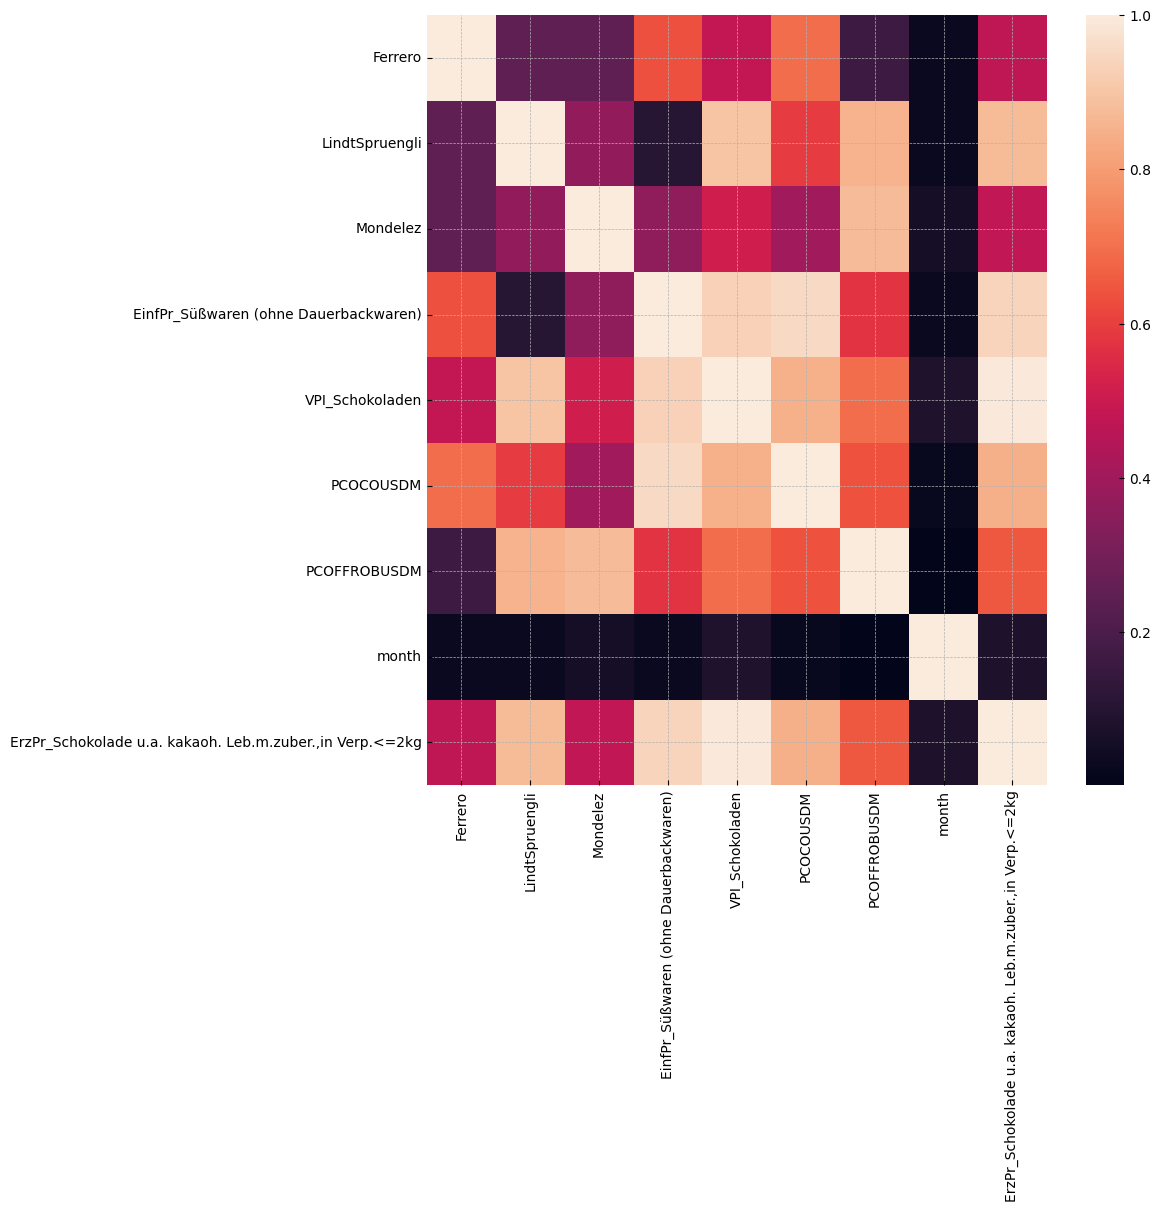

In [53]:
corr = df.loc[:,list(dict_lag)].corr()
fig_heatmap, ax_heatmap = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
sns.heatmap(corr.abs(), xticklabels=True, yticklabels=True, ax=ax_heatmap)

## Linear Regression

MSE on Train set:  42.3394325288226
MSE on Test set:  235.4337150249369
MSE on Train set:  35.283451360879525
MSE on Test set:  159.349523630906


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.36905379  2.12782656  0.48177123 -7.07530531 -1.47415433 -0.49671637
 -1.03182169 -0.26214505  8.07377323 -4.50725849 -0.55754805  0.21909466
  2.34997244  1.57712955 -1.24975611 -7.32460921 -1.2486868  -0.19506892
 -0.54647877  1.63464402  7.71308587 -4.94325092 -2.10427449 -0.59448187
  0.57957186 -1.32349889 -3.09926011]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -1.69938395  -8.0836472   -1.99443403  -7.30734024  -7.52050865
  -5.9518281    0.0998397  -15.31423115 -11.65731794]' has dt

(              pred_m   pred_mf   pred_mfl      final     target
 index                                                          
 2019-01-31  2.369054       NaN        NaN   2.369054   0.207187
 2019-02-28  2.127827       NaN        NaN   2.127827   2.208051
 2019-03-31  0.481771       NaN        NaN   0.481771  -0.367747
 2019-04-30 -7.075305       NaN        NaN  -7.075305  -1.450762
 2019-05-31 -1.474154       NaN        NaN  -1.474154  -0.543008
 ...              ...       ...        ...        ...        ...
 2024-10-31  4.586628 -3.590975        NaN   0.536990   1.749173
 2024-11-30  3.607257 -1.841172  -1.448850   0.306333   0.306333
 2024-12-31  5.303392  3.693438  12.669672  20.434410  20.434410
 2025-01-31 -2.592269  3.711973   1.104580   1.778236   1.778236
 2025-02-28  1.976593 -0.907154   0.519153   1.563292   1.563292
 
 [74 rows x 5 columns],
                pred_m    pred_mf  pred_mfl      final     target
 2025-02-28   1.976593  -0.907154  0.519153   1.563292   1.5632

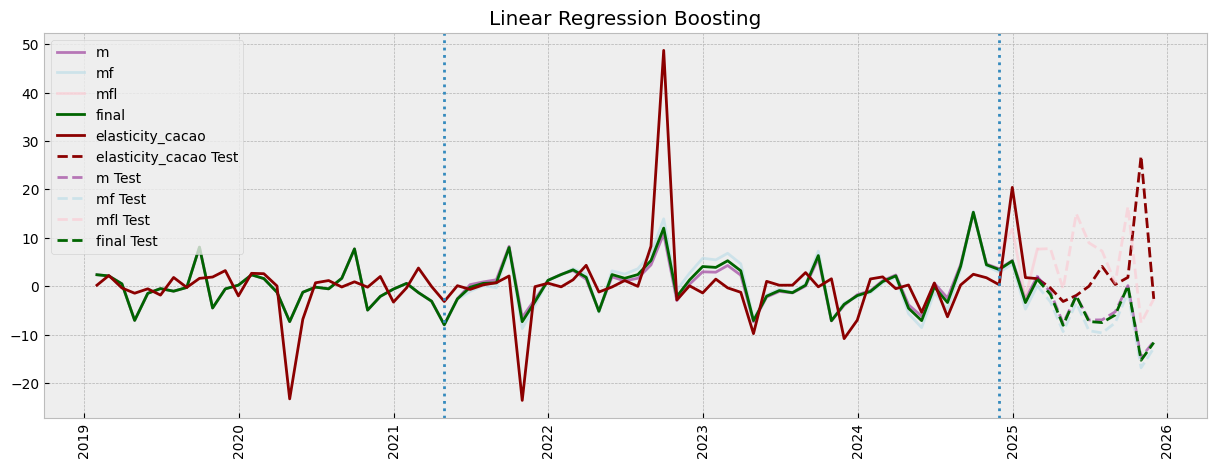

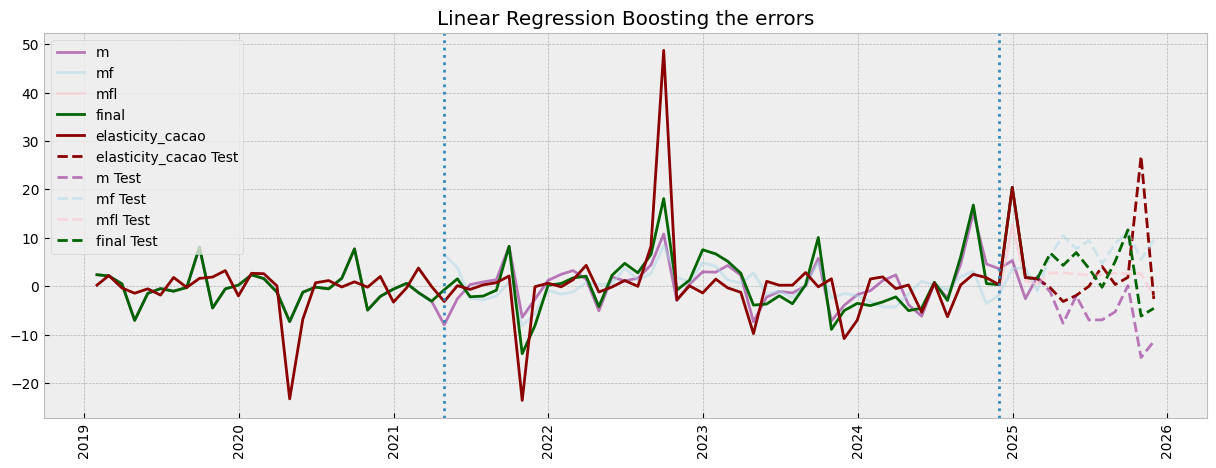

In [137]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()

name = 'Linear Regression Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear Regression Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


## LinearSVR

MSE on Train set:  56.602973510845814
MSE on Test set:  88.43069750277354
MSE on Train set:  50.79000090856698
MSE on Test set:  88.08406382873915


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.21222031  1.68209618 -0.24703405 -1.57778886 -0.55434096  0.23550099
  0.2569675  -0.0446076   1.61994323  0.00419402 -0.13940411 -1.59495112
  1.61308026  2.09930464 -0.22933866 -1.49771186 -0.58350232  0.13901257
  0.11030741 -0.06410442  1.50775762 -0.08351004 -0.19436581 -1.72972106
  1.31411312  1.59601693 -0.26803221]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.44057246 -1.06255659 -0.20792391  0.19972294  0.08835616 -0.53891117
  0.80591593 -0.82442749 -1.08385818]' has dtype incom

(              pred_m   pred_mf   pred_mfl      final     target
 index                                                          
 2019-01-31  1.215057       NaN        NaN   1.215057   0.207187
 2019-02-28  1.683817       NaN        NaN   1.683817   2.208051
 2019-03-31 -0.242970       NaN        NaN  -0.242970  -0.367747
 2019-04-30 -1.572935       NaN        NaN  -1.572935  -1.450762
 2019-05-31 -0.543008       NaN        NaN  -0.543008  -0.543008
 ...              ...       ...        ...        ...        ...
 2024-10-31  0.676497  0.400928        NaN   1.009776   1.749173
 2024-11-30  0.305680  0.050067  -0.009790   0.305875   0.306333
 2024-12-31 -1.164169  0.813686  16.802586  16.413920  20.434410
 2025-01-31  1.403182  0.515132   0.098115   1.778236   1.778236
 2025-02-28  2.058281 -0.297572  -0.048740   1.562680   1.563292
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 20

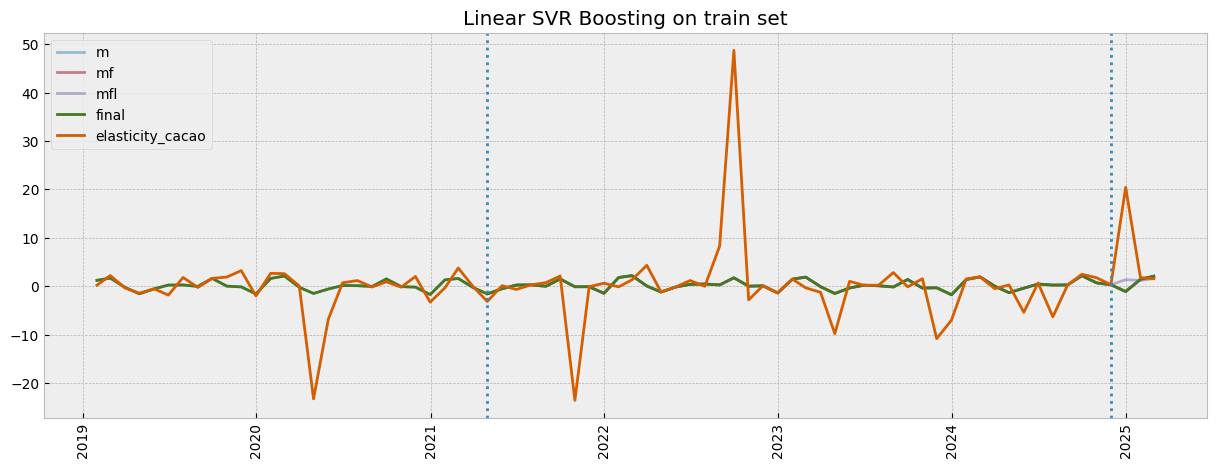

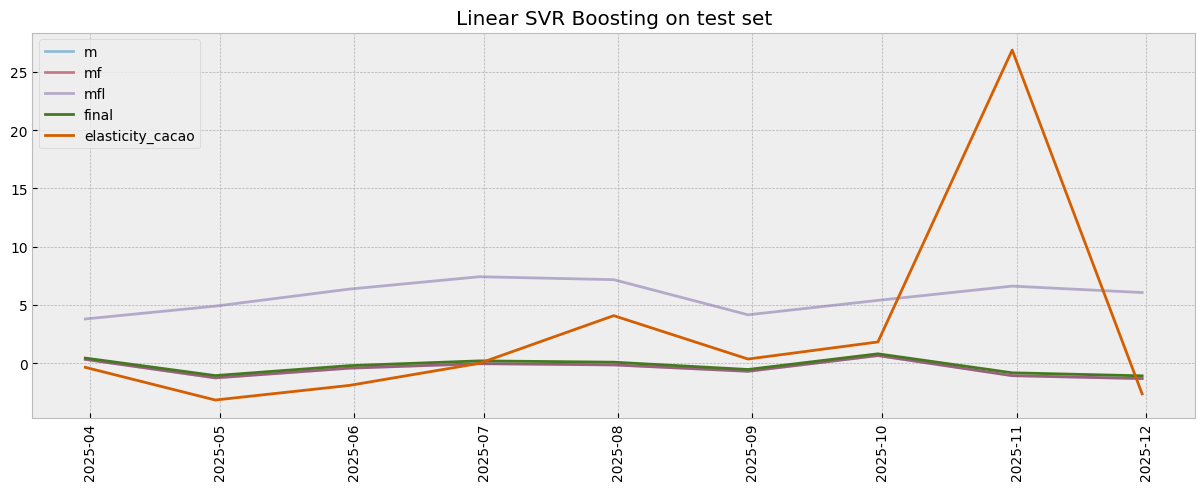

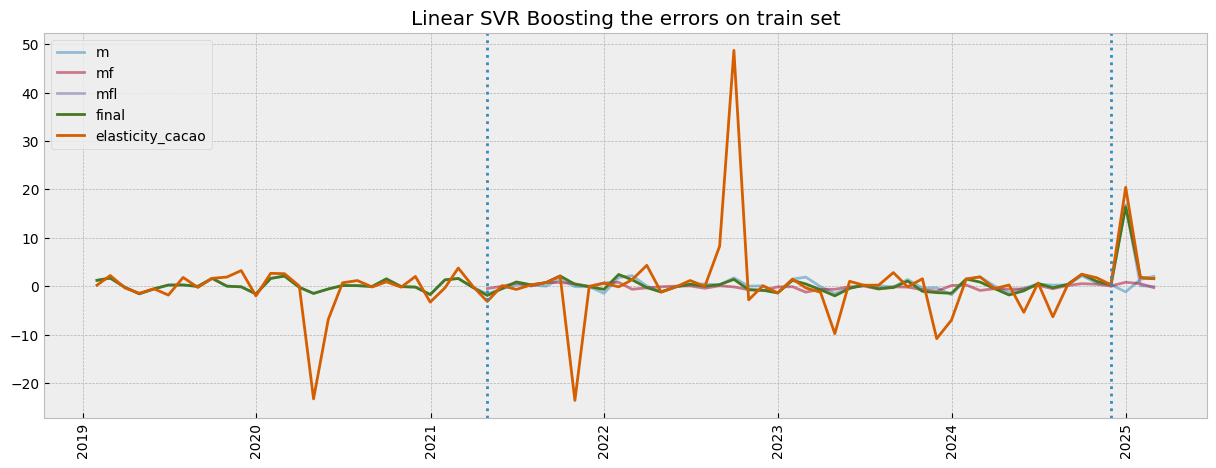

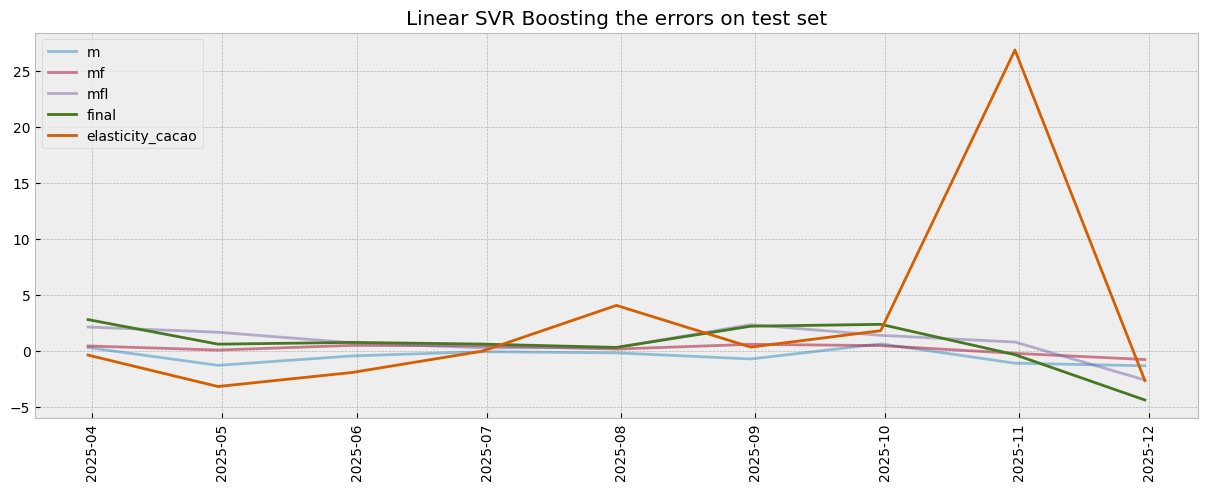

In [68]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()


name = 'Linear SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


MSE on Train set:  55.3114807224204
MSE on Test set:  77.74163289392303
MSE on Train set:  53.32250033838749
MSE on Test set:  77.02242272719872


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.28462555  1.87178489 -0.04616518 -1.35090312 -0.44350241  0.1178024
  0.62741849  0.2207277   1.37300692 -0.11379739  0.81187862 -1.2651442
  0.33802303  1.73003697 -0.05441116 -1.39157496 -0.44257026  0.12185744
  0.63924835  0.20583254  1.35117228 -0.10013804  0.79975651 -1.26207444
  0.33626105  1.85397481 -0.10912355]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.41158677 0.85859569 0.52813015 0.93924355 0.38060523 0.59613304
 1.23879612 1.36878176 0.68836028]' has dtype incompatible wit

(              pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 2019-01-31  0.284626       NaN       NaN  0.284626   0.207187
 2019-02-28  1.871785       NaN       NaN  1.871785   2.208051
 2019-03-31 -0.046165       NaN       NaN -0.046165  -0.367747
 2019-04-30 -1.350903       NaN       NaN -1.350903  -1.450762
 2019-05-31 -0.443502       NaN       NaN -0.443502  -0.543008
 ...              ...       ...       ...       ...        ...
 2024-10-31  1.638931  0.193463       NaN  1.668501   1.749173
 2024-11-30  0.297258 -0.061345  0.188814  0.406657   0.306333
 2024-12-31  0.884539  0.460955  0.974005  2.143464  20.434410
 2025-01-31  1.678155  0.168161  0.232010  1.878560   1.778236
 2025-02-28  1.463396  0.197841  0.185336  1.662644   1.563292
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final     target
 index                                                        
 2025-03-31  0.458076  0.0373

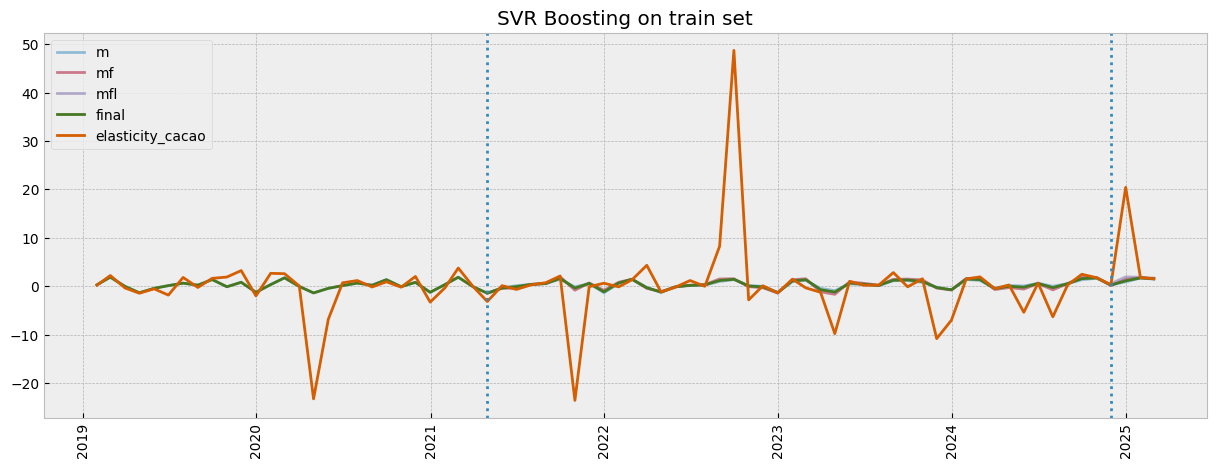

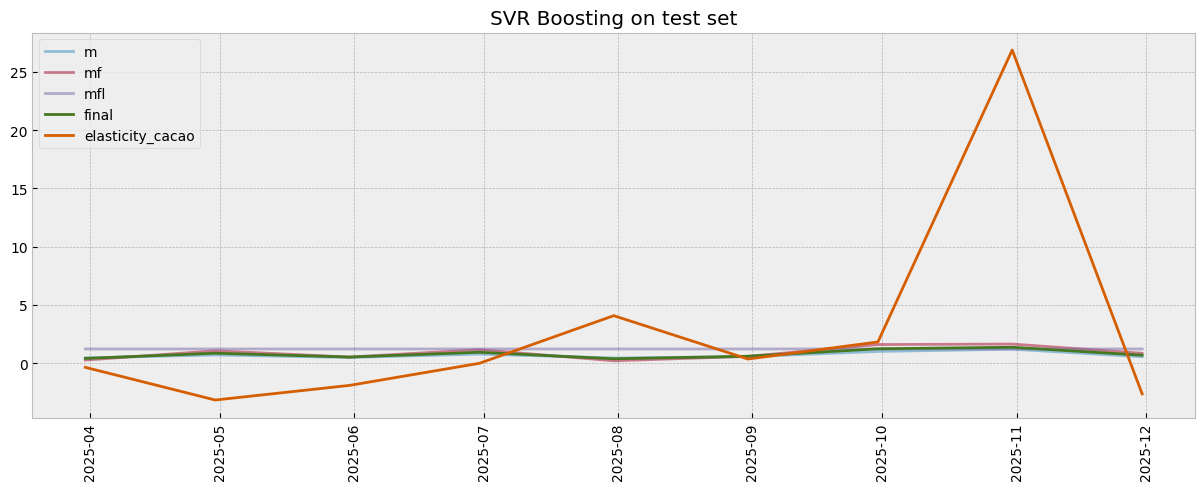

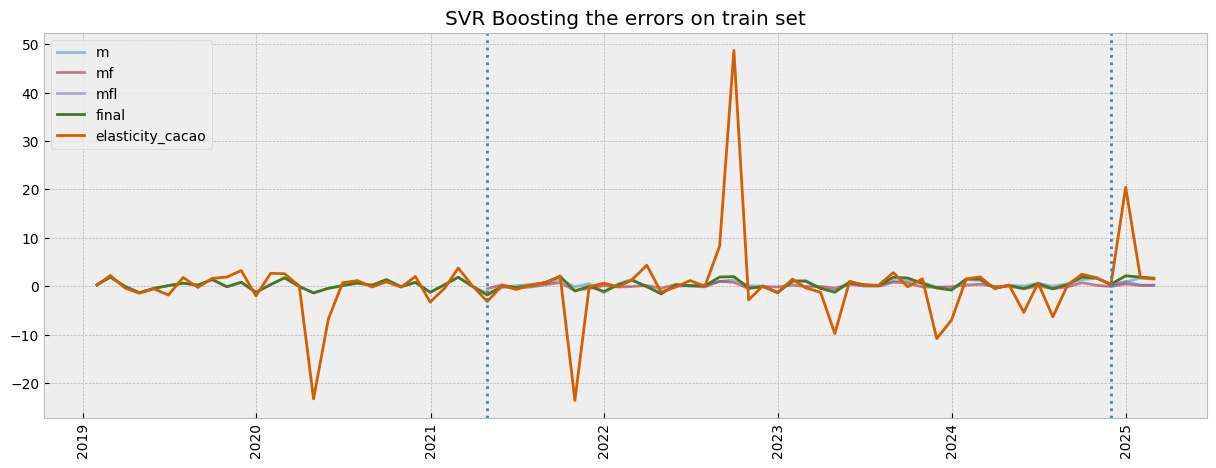

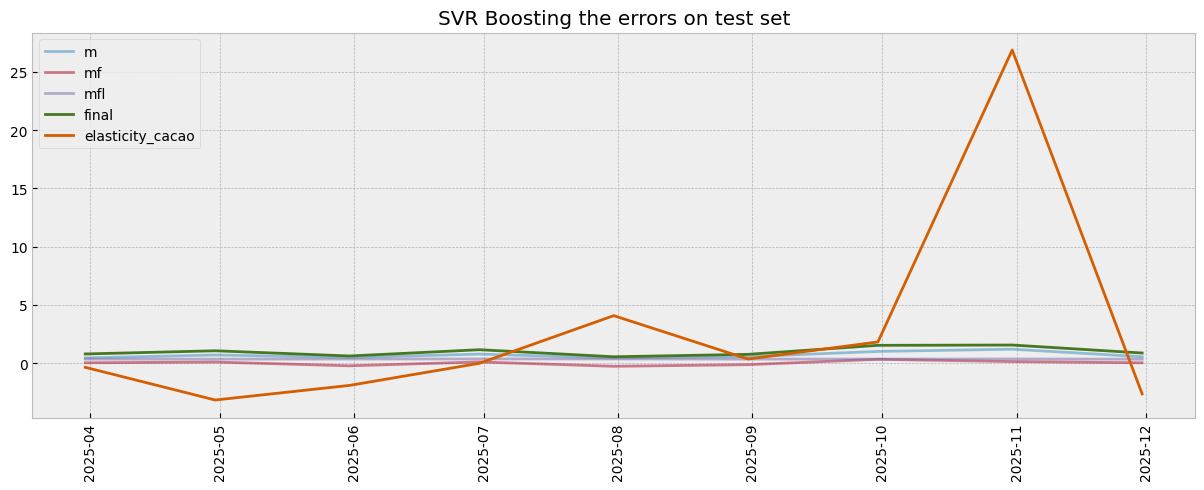

In [69]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()

name = 'SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


## Random Forest

MSE on Train set:  20.569189870675068
MSE on Test set:  113.25697673741979
MSE on Train set:  8.506690325625739
MSE on Test set:  176.43882810044232


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.39631459   1.26731084   0.39631459  -9.46631299  -0.1065839
   0.53517019   0.80939842   0.43034275  10.32146324   1.29561103
   0.06067775  -0.105492     0.97616345   0.96050001   0.43034275
 -23.29519975   9.58546539   0.43034275   0.50114204   0.33820013
   0.64387245   0.49733781   9.79679955  -0.84593316   0.43034275
   0.53517019   0.53517019]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 6.61015395 -2.61271038  6.61015395  6.61015395  6.61015395 10.44490218
  4.62208516  4.73636477 13

(              pred_m    pred_mf  pred_mfl      final     target
 index                                                          
 2019-01-31  0.457275        NaN       NaN   0.457275   0.207187
 2019-02-28  0.457275        NaN       NaN   0.457275   2.208051
 2019-03-31  0.457275        NaN       NaN   0.457275  -0.367747
 2019-04-30 -5.955931        NaN       NaN  -5.955931  -1.450762
 2019-05-31 -1.799516        NaN       NaN  -1.799516  -0.543008
 ...              ...        ...       ...        ...        ...
 2024-10-31  0.294815   0.733821       NaN   0.999155   1.749173
 2024-11-30  0.075000  -0.466349 -1.471971  -1.782214   0.306333
 2024-12-31  7.962847  10.748671  4.561425  20.434410  20.434410
 2025-01-31  1.185766   3.124956  4.561425   8.159828   1.778236
 2025-02-28  0.620712   3.057557 -1.471971   1.563292   1.563292
 
 [74 rows x 5 columns],
                pred_m   pred_mf  pred_mfl      final     target
 index                                                          

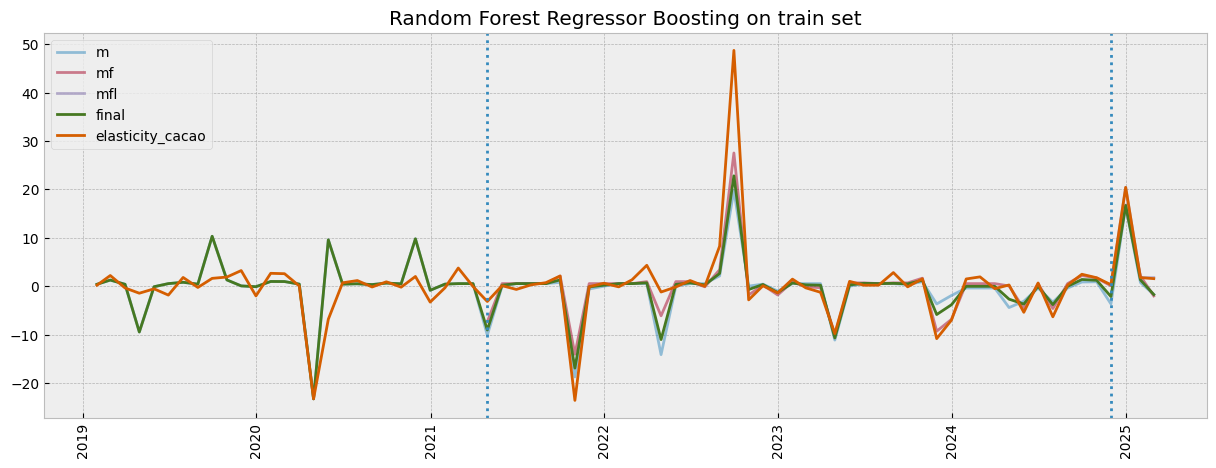

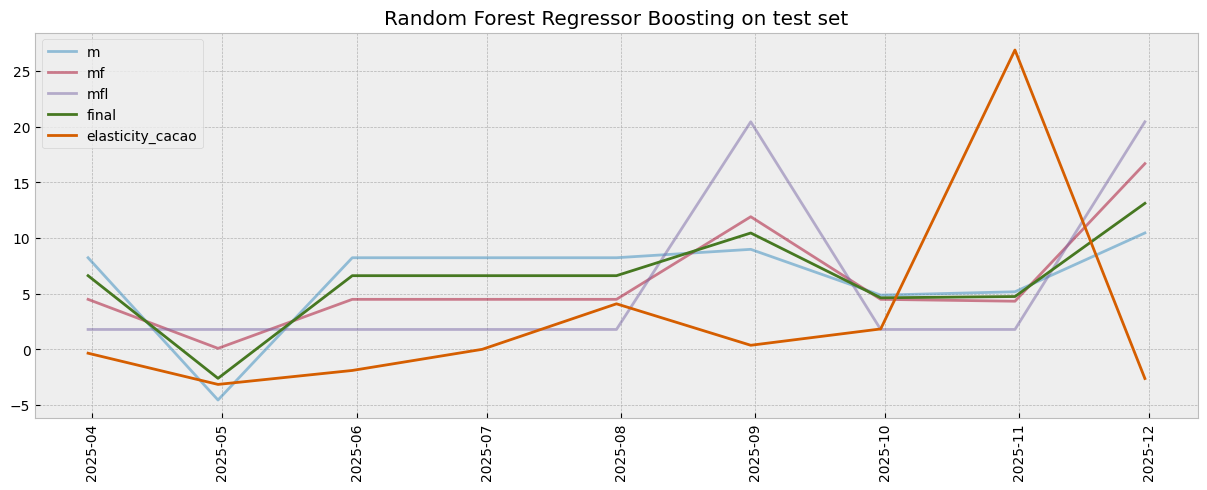

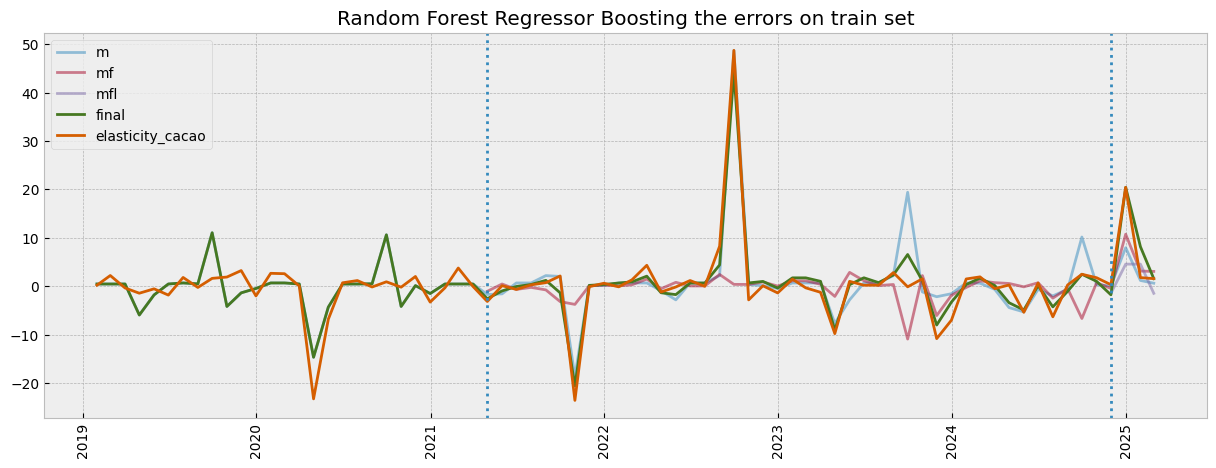

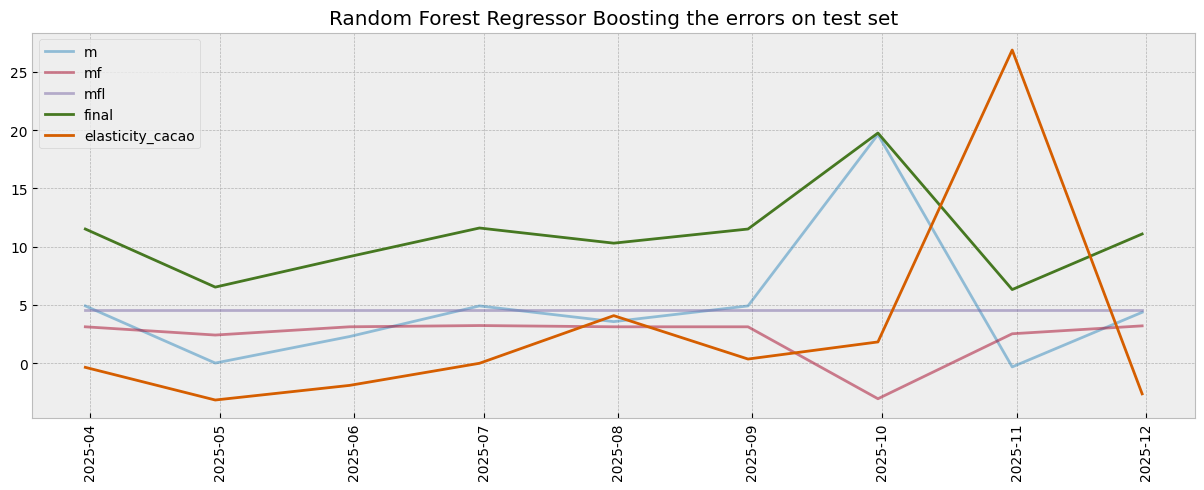

In [70]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5)

name = 'Random Forest Regressor Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Random Forest Regressor Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### ANN

In [36]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_cacao'
number_train = 74
shares = []#'Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in [#'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})


In [37]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

In [38]:
features_train_transf

,EinfPr_Süßwaren (ohne Dauerbackwaren)_lag_by_1,VPI_Schokoladen_lag_by_1,PCOCOUSDM_lag_by_1,PCOFFROBUSDM_lag_by_1,"ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg"
date,,,,,
2019-01-31,-0.542647,-0.930059,-0.558055,-0.861998,-0.875314
2019-02-28,-0.542647,-0.930059,-0.558055,-0.861998,-0.875314
2019-03-31,-0.545531,-0.884924,-0.561615,-0.876708,-0.890407
2019-04-30,-0.539763,-0.807550,-0.587772,-1.009292,-0.882860
2019-05-31,-0.545531,-0.891372,-0.525999,-0.999687,-0.882860
...,...,...,...,...,...
2024-10-31,2.393195,1.874757,1.408192,1.580424,1.916960
2024-11-30,2.323981,1.887653,1.484332,0.949750,1.962240
2024-12-31,2.745035,1.932788,2.116251,1.025530,1.984880


Epoch 1/50


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 60.9923 - val_loss: 84.9199
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.7545 - val_loss: 83.7612
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.5894 - val_loss: 82.1312
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.4130 - val_loss: 80.9637
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.0962 - val_loss: 80.8834
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.9986 - val_loss: 79.5260
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.7020 - val_loss: 77.8438
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.1015 - val_loss: 77.0920
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.6237 - val_loss: 76.3955
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.3448 - val_loss: 76.8096
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8554 - val_loss: 77.3612
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.3

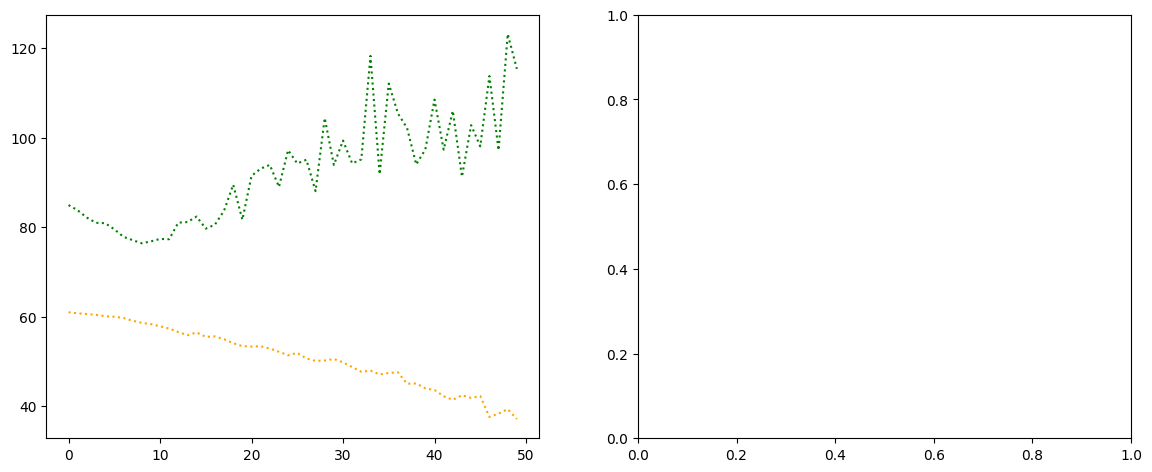

In [91]:
model_an = Sequential()
model_an.add(Dense(50,  activation="relu", input_shape=(features_train_transf.shape[1],)))#activation='sigmoid',
#model_an.add(Dense(500, activation = 'relu'))
model_an.add(Dense(20, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mse,
                optimizer = 'adam',
                #metrics = ["mae"]
                )  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=50, 
                    batch_size=1,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
MSE on Train set:  33.842910597435704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
MSE on Test set:  115.33885439209502


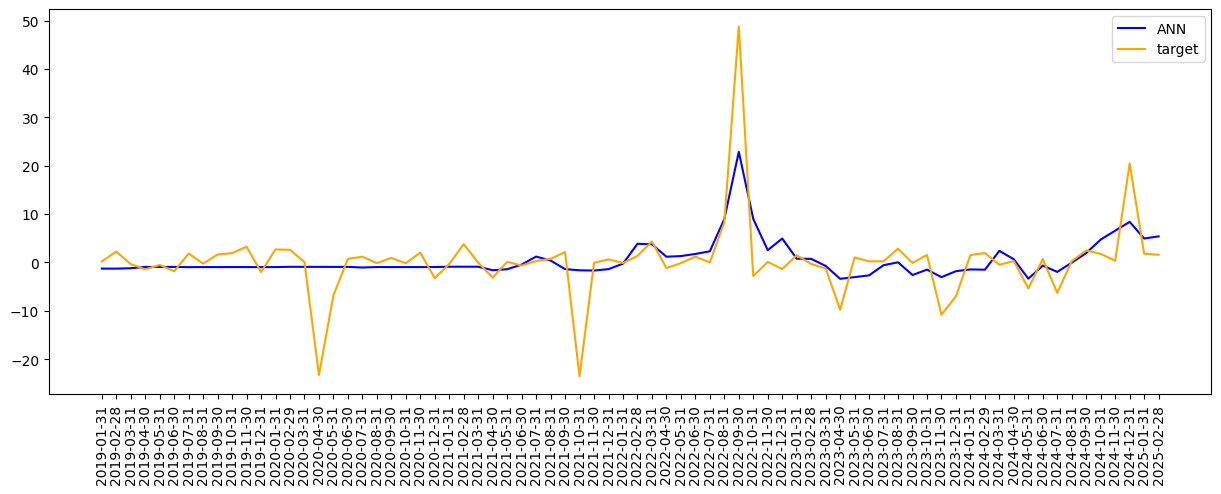

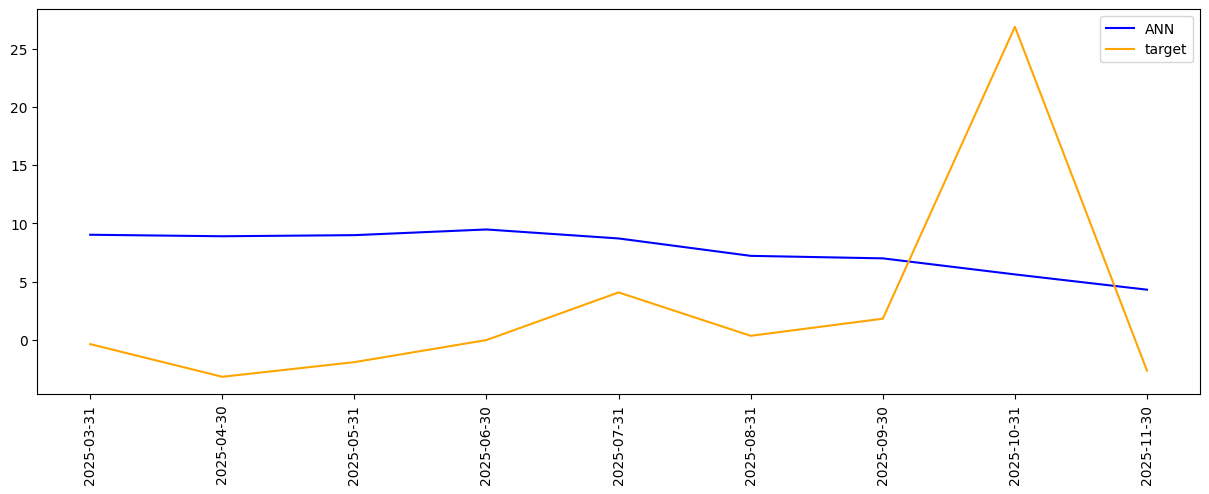

In [ ]:

results = model_an.predict(features_train_transf)
print('MSE on Train set: ', mean_squared_error(results, target_train))
#results['target']=target_train
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(target_train.index,results, label = 'ANN', color = 'blue');
ax.plot(target_train.index, target_train,  label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax.legend()
# Predict testdata 
results_test = model_an.predict(features_test_transf)
#results_test['target']=target_test
print('MSE on Test set: ', mean_squared_error(results_test, target_test))
fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax_test.plot(target_test.index,results_test, label = 'ANN', color = 'blue');
ax_test.plot(target_test.index,target_test, label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax_test.legend()

## Coffee elasticity

In [74]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_coffee'
number_train = 74
shares = ['Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in [#'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})

### Linear Regression

MSE on Train set:  19.617510058189083
MSE on Test set:  3.50327091151984
MSE on Train set:  18.479225993692065
MSE on Test set:  1.6426746221908237


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.31349389 -4.72684378  1.25316021 -1.89660525  0.23918523  0.44455887
  0.06797918 -0.668513   -0.21040672 -0.46643114  2.14410013  1.37512217
  1.04543087 -4.04276136  1.38241913 -1.55608356  0.3492      0.58664707
 -0.01298875 -0.26901016 -0.12428408 -0.30789594  1.85075253  1.23046204
  0.7485091  -4.93560935  0.80937278]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.04543892 -1.78490286 -0.21298646 -0.82643173 -1.04138718 -1.92318893
 -1.69116777 -2.36936547 -1.07980877]' has dtype incom

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31  0.313494       NaN       NaN  0.313494  0.092550
 2019-02-28 -4.726844       NaN       NaN -4.726844  6.430267
 2019-03-31  1.253160       NaN       NaN  1.253160 -0.744450
 2019-04-30 -1.896605       NaN       NaN -1.896605 -0.002626
 2019-05-31  0.239185       NaN       NaN  0.239185 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31  0.794551 -1.683569       NaN -0.968473  0.203823
 2024-11-30  2.498327 -0.006057 -2.286632 -0.043044 -0.043044
 2024-12-31  1.830064 -2.627810  0.160503 -0.320965 -0.320965
 2025-01-31  0.817859  1.089065 -0.528733  1.089483  1.089483
 2025-02-28 -3.147601  2.366839  0.689479 -0.226222 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2025-03-31 -0.108910  0.601353  0.325796  0

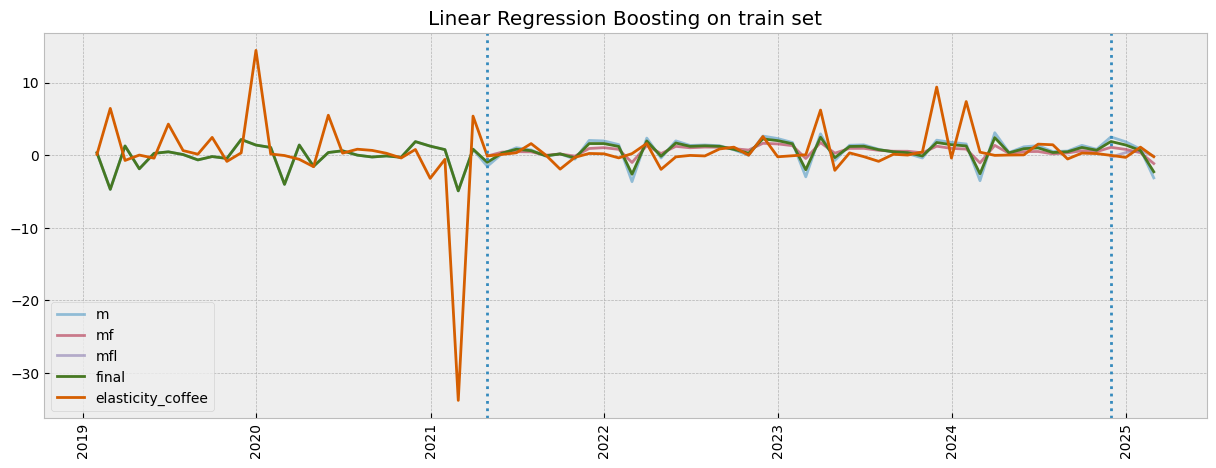

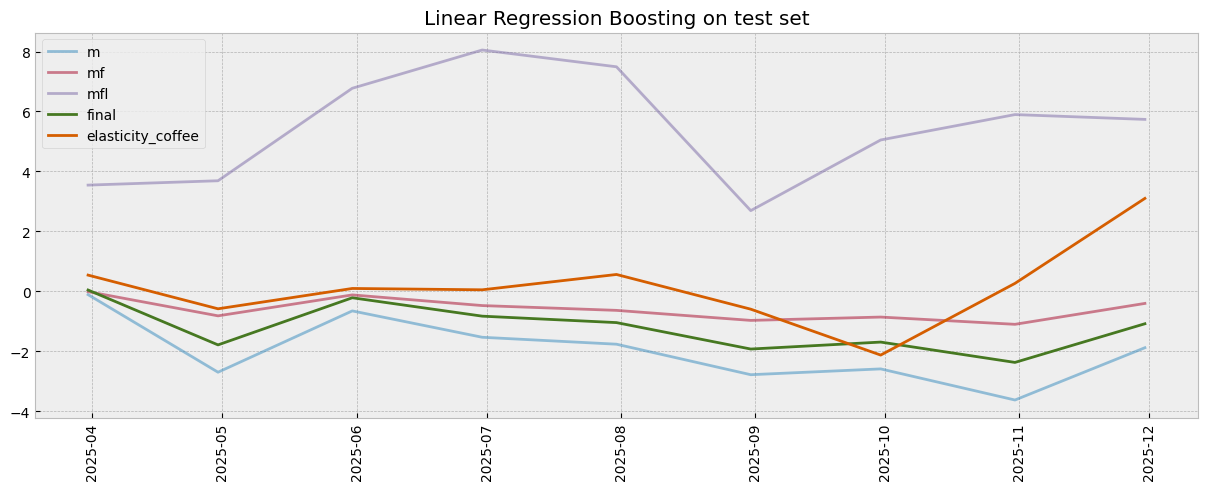

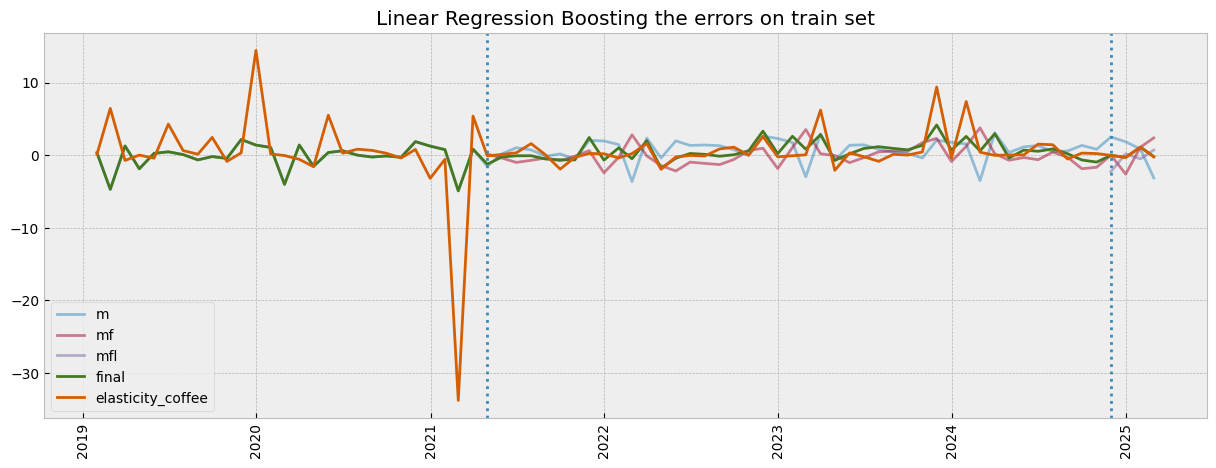

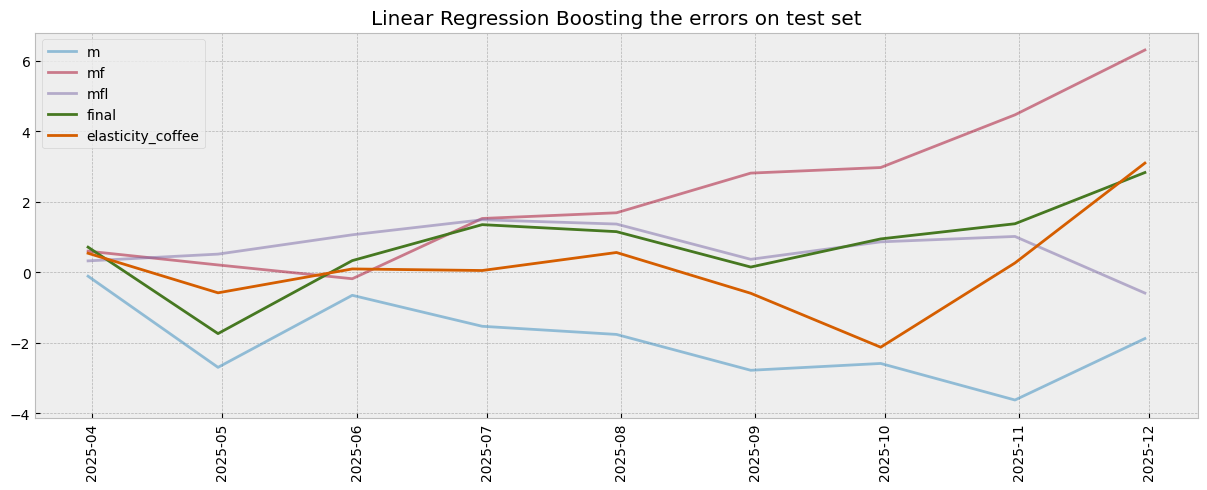

In [75]:
model_start = LinearRegression()
model_middle = LinearRegression()
model_end = LinearRegression()

name = 'Linear Regression Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear Regression Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### Linear SVR


MSE on Train set:  23.203137889382244
MSE on Test set:  1.4754184883057064
MSE on Train set:  22.78458348873735
MSE on Test set:  1.4296888458102601


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.32209242  0.54791916  0.26888485 -0.10239804  0.06330286  0.24145805
  0.62039102  0.09967658  0.20914597 -0.20711107  0.3034582  -0.26674905
 -0.19021166  0.0490129   0.08211509 -0.27019436  0.0290961   0.25950622
  0.80612292  0.09729426  0.19820301 -0.26770862  0.22687263 -0.24903296
 -0.07457833  0.34060503  0.11638329]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.30331812 -0.57024964 -0.38845983 -0.11156324  0.31357392 -0.03487214
  0.10035859 -0.21350457  0.50441542]' has dtype incom

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31  0.318833       NaN       NaN  0.318833  0.092550
 2019-02-28  0.545132       NaN       NaN  0.545132  6.430267
 2019-03-31  0.266517       NaN       NaN  0.266517 -0.744450
 2019-04-30 -0.103278       NaN       NaN -0.103278 -0.002626
 2019-05-31  0.061901       NaN       NaN  0.061901 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31 -0.246413  0.137075       NaN -0.084697  0.203823
 2024-11-30  0.143847  0.059263 -0.220465 -0.042999 -0.043044
 2024-12-31 -0.282076 -0.066858 -0.012873 -0.320896 -0.320965
 2025-01-31 -0.289674  0.257373  1.141718  1.089483  1.089483
 2025-02-28 -0.225547 -0.021833 -0.005444 -0.226122 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2025-03-31 -0.294536  0.980137  0.347306  0

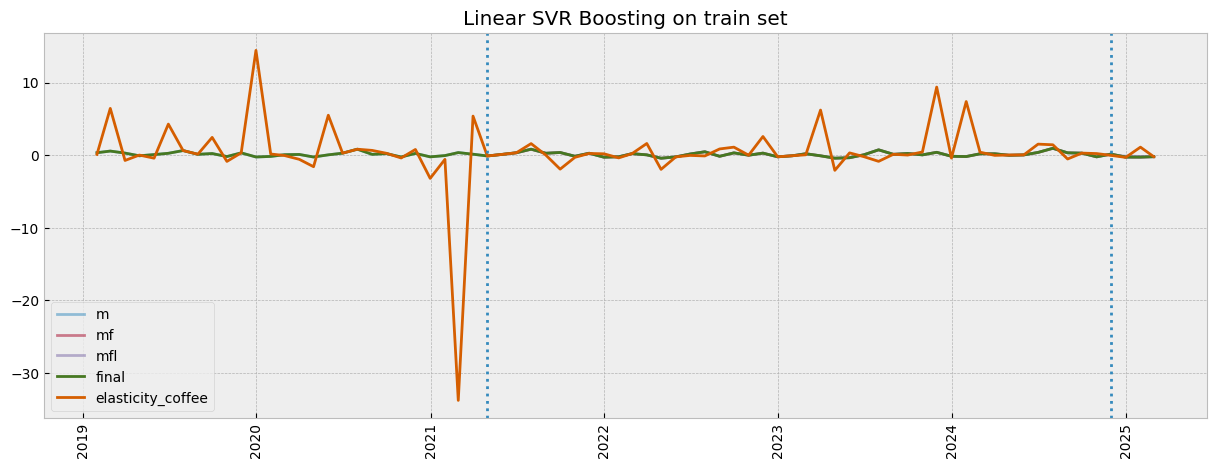

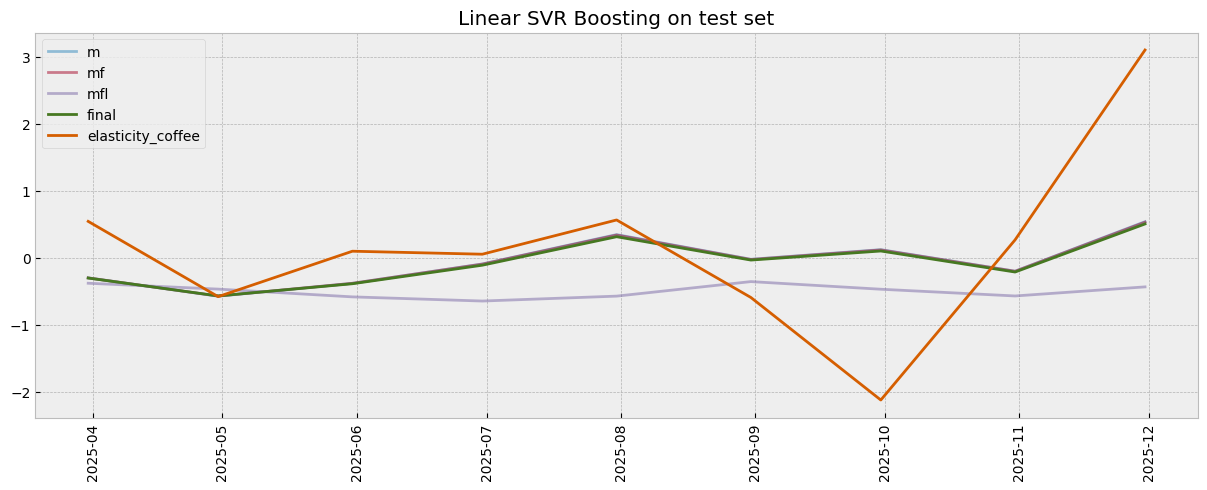

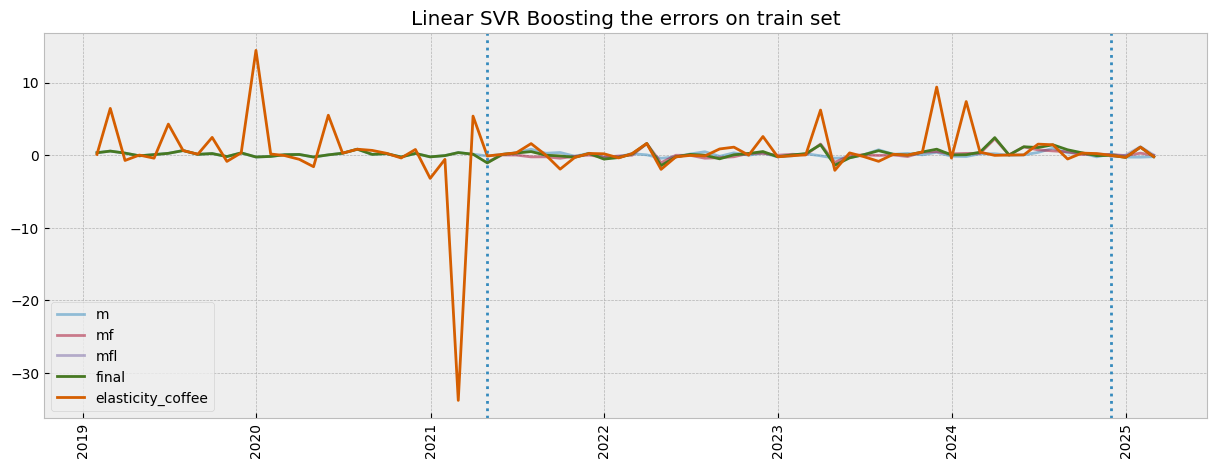

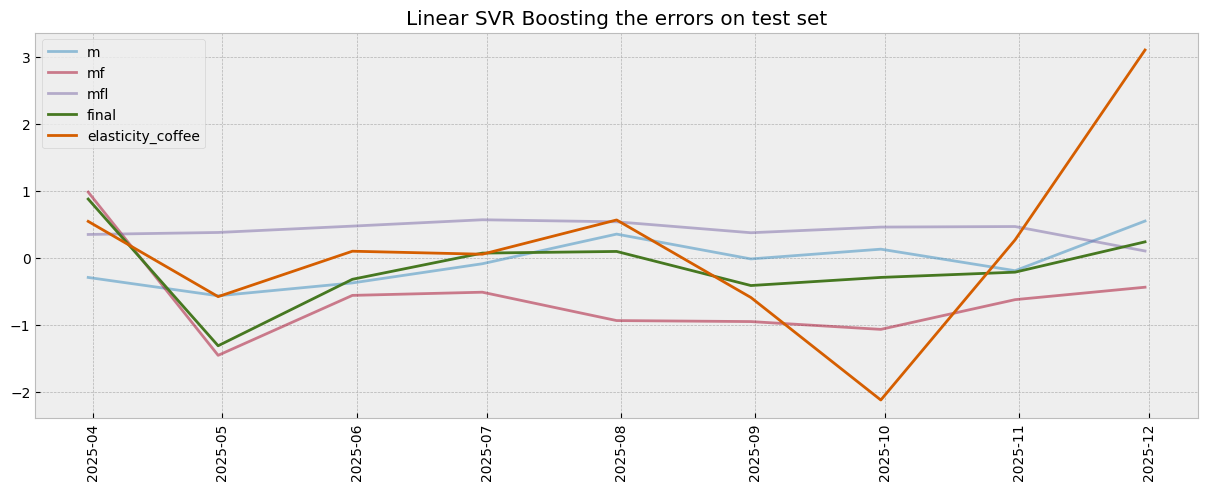

In [76]:
model_start = LinearSVR()
model_middle = LinearSVR()
model_end = LinearSVR()


name = 'Linear SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Linear SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### SVR

MSE on Train set:  22.11717144095971
MSE on Test set:  1.8081177667017583
MSE on Train set:  21.89385344680175
MSE on Test set:  1.8965387395799413


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00707646  0.13014673  0.26493409 -0.10258836  0.01229683  0.33423534
  0.66166182  0.21697057  0.34581009 -0.38506503  0.40378029  0.17565578
 -0.16712826  0.03367862  0.30549854 -0.21990009  0.01410338  0.35955641
  0.70526017  0.22395745  0.34421639 -0.39017841  0.40933152  0.17721947
 -0.12947815  0.07785645  0.41974415]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.00171574  0.08276342  0.08378822  0.47549614  0.51837285 -0.1905619
  0.16084135  0.20075625 -0.0553349 ]' has dtype incomp

(              pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2019-01-31 -0.007076       NaN       NaN -0.007076  0.092550
 2019-02-28  0.130147       NaN       NaN  0.130147  6.430267
 2019-03-31  0.264934       NaN       NaN  0.264934 -0.744450
 2019-04-30 -0.102588       NaN       NaN -0.102588 -0.002626
 2019-05-31  0.012297       NaN       NaN  0.012297 -0.432072
 ...              ...       ...       ...       ...       ...
 2024-10-31  0.303845  0.030208       NaN  0.303669  0.203823
 2024-11-30  0.057344  0.005385 -0.061933 -0.005962 -0.043044
 2024-12-31 -0.221078 -0.022101 -0.061933 -0.278806 -0.320965
 2025-01-31  0.989710  0.269776 -0.061933  1.047324  1.089483
 2025-02-28 -0.126199 -0.012907 -0.061933 -0.185967 -0.226222
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl     final    target
 index                                                       
 2025-03-31  0.001231 -0.109318 -0.061933 -0

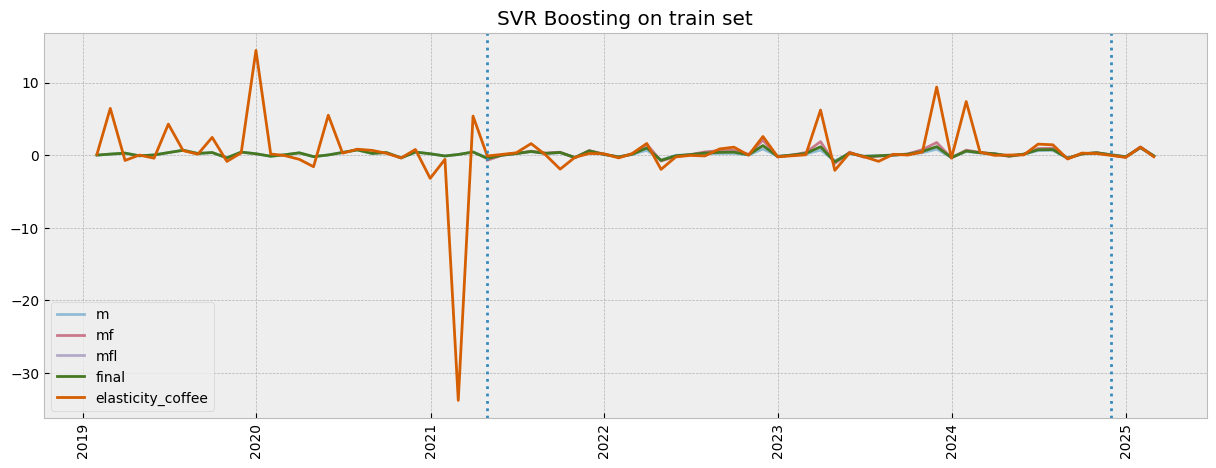

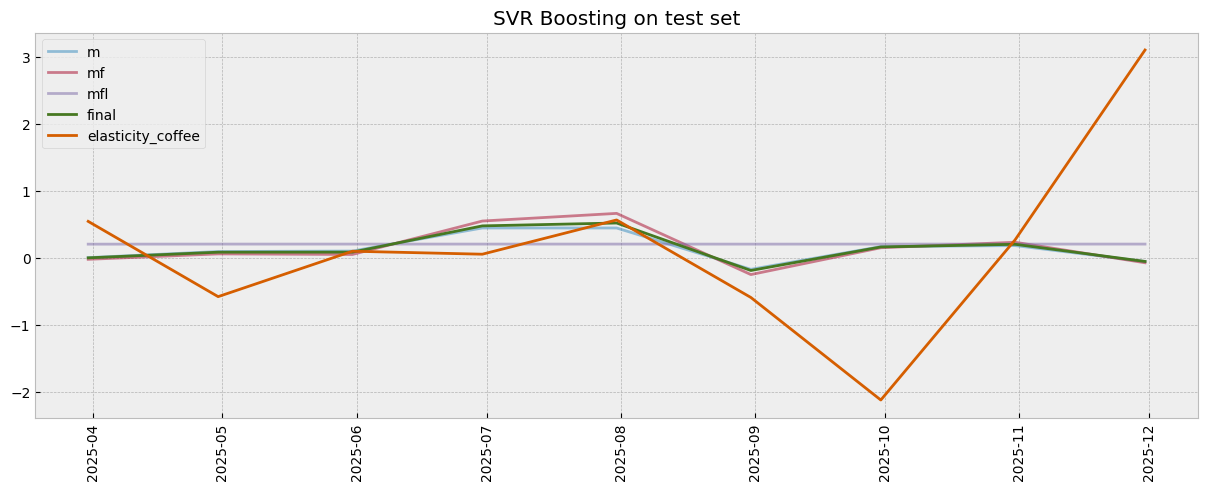

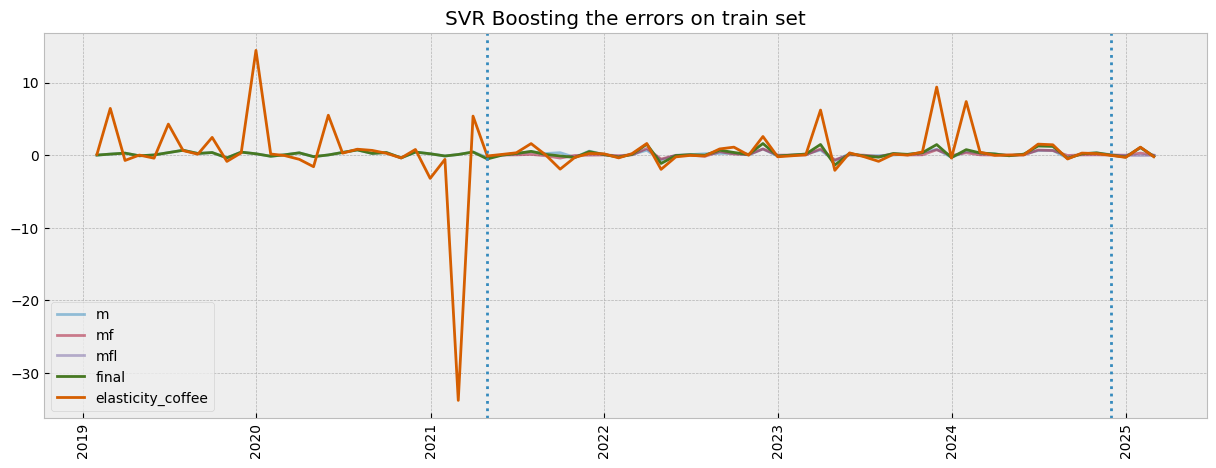

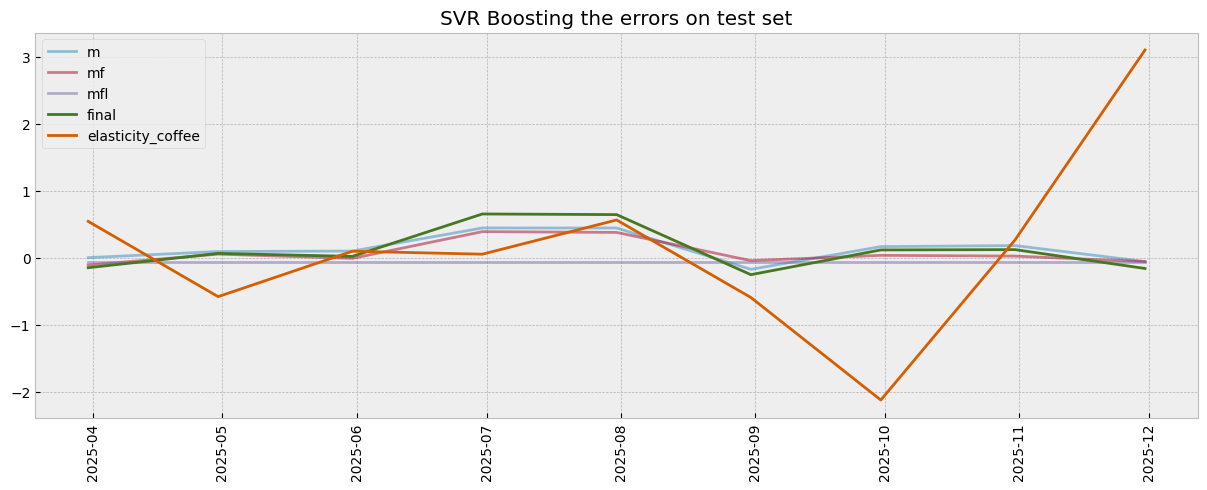

In [77]:
model_start = SVR()
model_middle = SVR()
model_end = SVR()

name = 'SVR Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'SVR Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


### Random Forest

C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.69643796   0.69643796   0.449873    -1.47784883  -0.98321968
   0.69643796   0.69643796   0.449873     1.22035306  -4.16262575
   0.65128173  -0.42346241   0.69643796   0.69643796   0.69643796
 -17.45338839  -0.73665473   0.69643796   0.449873     2.13935855
  10.50527337  -4.16262575   0.65128173  -1.049138     0.449873
   0.53000137   0.53000137]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2570047379.py:94: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[6.22310485 2.23402433 6.22310485 6.22310485 6.22310485 6.22310485
 1.14414238 6.13019324 6.13019324]

MSE on Train set:  10.978608982391915
MSE on Test set:  80.46132801311724
MSE on Train set:  7.643116638832041
MSE on Test set:  134.15585694953205


(               pred_m   pred_mf  pred_mfl      final     target
 index                                                          
 2019-01-31   0.696438       NaN       NaN   0.696438   0.207187
 2019-02-28   0.696438       NaN       NaN   0.696438   2.208051
 2019-03-31   0.449873       NaN       NaN   0.449873  -0.367747
 2019-04-30  -1.477849       NaN       NaN  -1.477849  -1.450762
 2019-05-31  -0.983220       NaN       NaN  -0.983220  -0.543008
 ...               ...       ...       ...        ...        ...
 2024-10-31  -0.991987 -1.227903       NaN  -2.120692   1.749173
 2024-11-30  -0.945423  0.227480  3.860614   3.193992   0.306333
 2024-12-31  20.434410 -2.243423  3.860614  20.434410  20.434410
 2025-01-31   9.240705 -3.624649 -3.602433   1.778236   1.778236
 2025-02-28  -1.234272  0.753021  2.064190   1.563292   1.563292
 
 [74 rows x 5 columns],
               pred_m   pred_mf  pred_mfl      final     target
 index                                                         
 

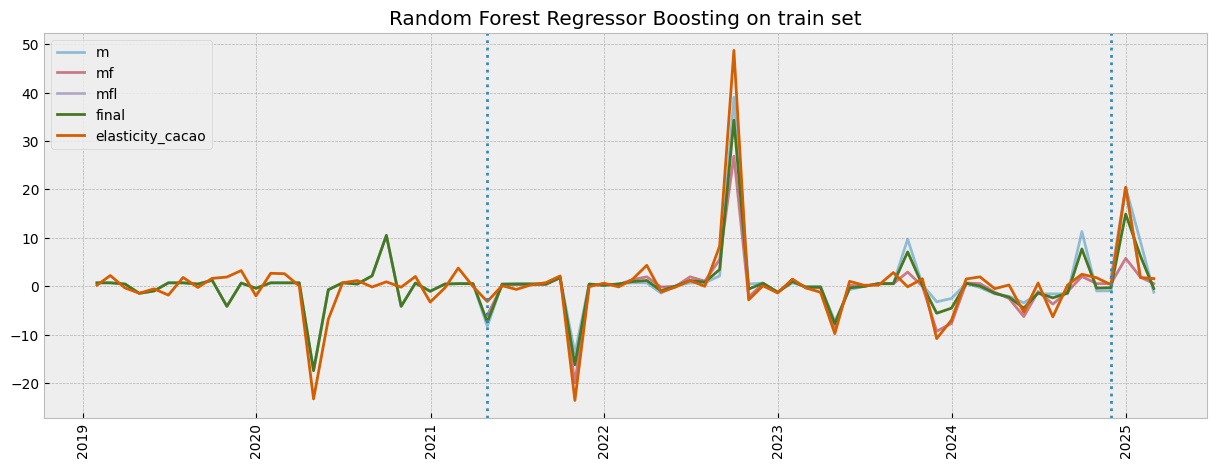

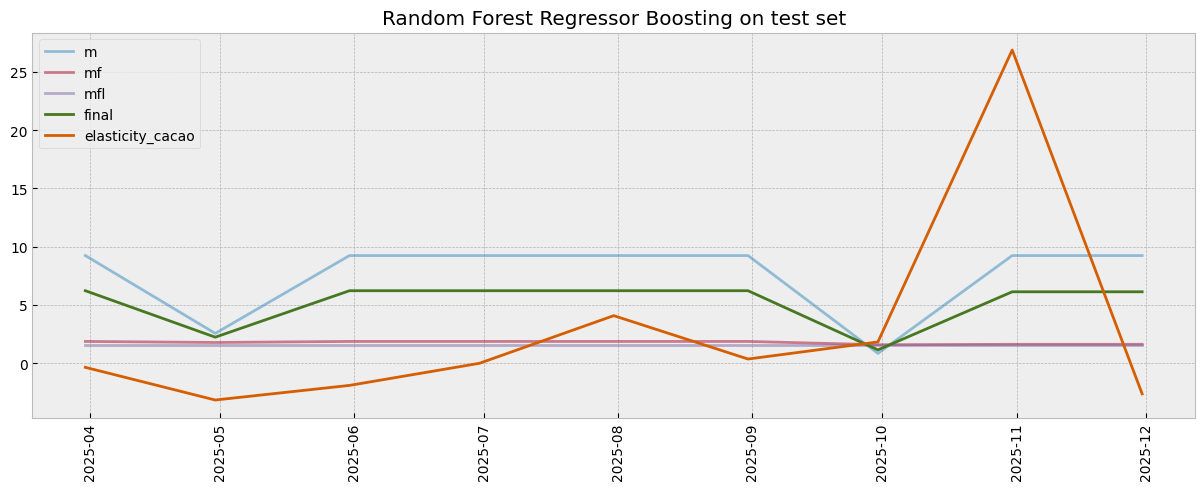

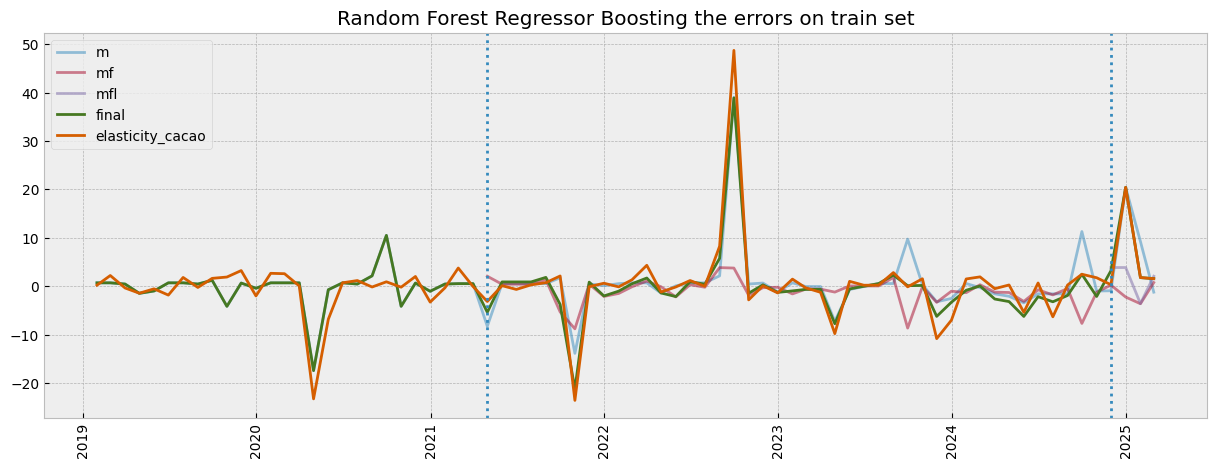

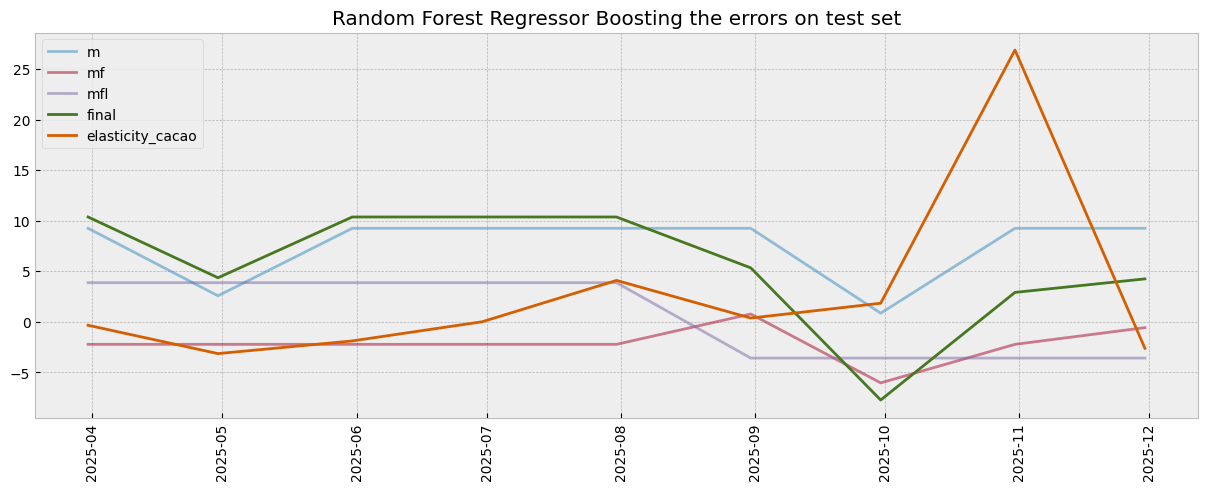

In [71]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5, random_state=42)

name = 'Random Forest Regressor Boosting'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name)

name2 = 'Random Forest Regressor Boosting the errors'
train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, name2, model_simple=1)


MSE on Train set:  7.643116638832041
MSE on Test set:  134.15585694953205


C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2495275163.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.69643796   0.69643796   0.449873    -1.47784883  -0.98321968
   0.69643796   0.69643796   0.449873     1.22035306  -4.16262575
   0.65128173  -0.42346241   0.69643796   0.69643796   0.69643796
 -17.45338839  -0.73665473   0.69643796   0.449873     2.13935855
  10.50527337  -4.16262575   0.65128173  -1.049138     0.449873
   0.53000137   0.53000137]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[mask_f, 'final'] = result.loc[mask_f, 'pred_m']
C:\Users\judit\AppData\Local\Temp\ipykernel_41256\2495275163.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.3600759   4.34694023 10.3600759  10.3600759  10.3600759   5.32709726
 -7.75211525  2.89702877  4.

,pred_m,pred_mf,pred_mfl,final,target
index,,,,,
2019-01-31,0.696438,NaN,NaN,0.696438,0.207187
2019-02-28,0.696438,NaN,NaN,0.696438,2.208051
2019-03-31,0.449873,NaN,NaN,0.449873,-0.367747
2019-04-30,-1.477849,NaN,NaN,-1.477849,-1.450762
2019-05-31,-0.983220,NaN,NaN,-0.983220,-0.543008
...,...,...,...,...,...
2024-10-31,-0.991987,-1.227903,NaN,-2.120692,1.749173
2024-11-30,-0.945423,0.227480,3.860614,3.193992,0.306333
2024-12-31,20.434410,-2.243423,3.860614,20.434410,20.434410


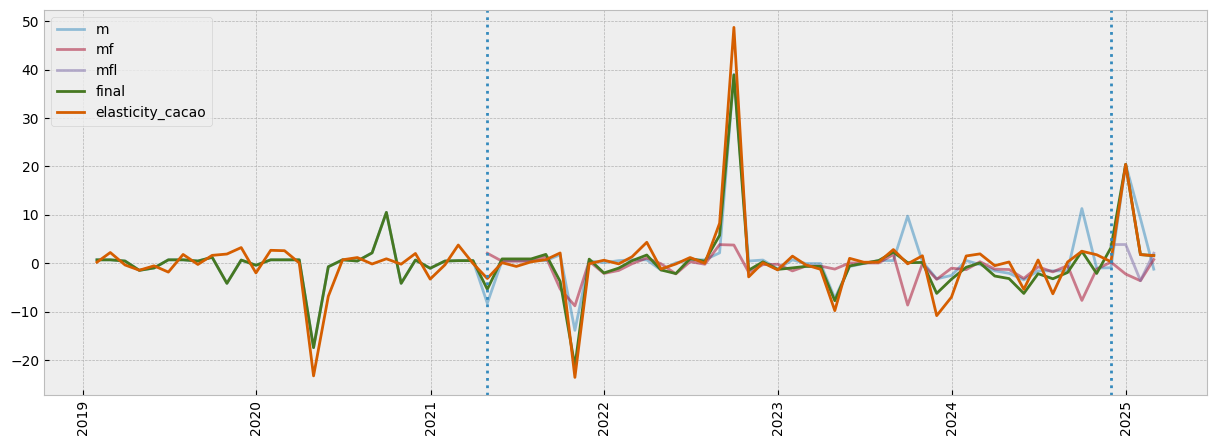

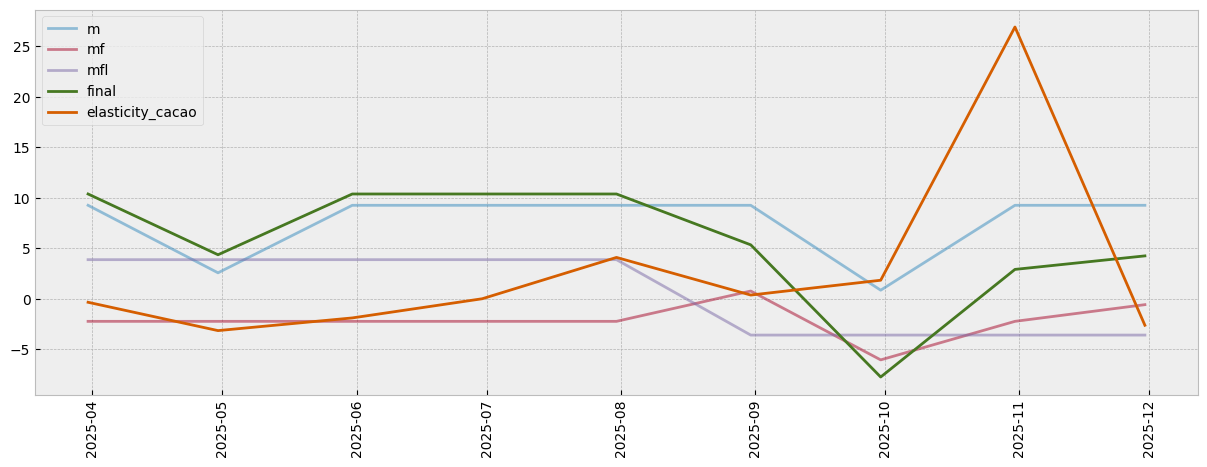

In [58]:
model_start = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_middle = RandomForestRegressor(n_estimators=5, max_depth=5, random_state=42)
model_end = RandomForestRegressor(n_estimators=1, max_depth=5, random_state=42)
results, results_test = train_model_combination(df, dict_lag, model_start, model_middle, model_end, number_train, target_name, model_simple=1)
results

### ANN

In [78]:
columns = [#'Beschäftigte_WZ08-1082',
 #'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']
target_name = 'elasticity_coffee'
number_train = 74
shares = []#'Ferrero', 'LindtSpruengli', 'Mondelez']
dict_lag = {}
for k in shares:
    dict_lag.update({k: [0]})
for k in [#'Beschäftigte_WZ08-1082',
 #'Umsatz_WZ08-1082',
 'EinfPr_Süßwaren (ohne Dauerbackwaren)',
 'VPI_Schokoladen',
 'PCOCOUSDM',
 'PCOFFROBUSDM']:
    dict_lag.update({k: [1]})

for k in [#'Geleistete Arbeitsstunden_WZ08-1082',
 #'Bruttolohn- und -gehaltssumme_WZ08-1082',
 'month',
 'ErzPr_Schokolade u.a. kakaoh. Leb.m.zuber.,in Verp.<=2kg']:
    dict_lag.update({k: [0]})

In [79]:
features_train_transf, features_test_transf, target_train, target_test, columns = preprocessing(df, dict_lag,number_train, target_name)

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 23.0189 - val_loss: 1.3705
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.8042 - val_loss: 1.5137
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.5638 - val_loss: 1.3860
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1888 - val_loss: 1.3828
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.9165 - val_loss: 1.1785
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.6504 - val_loss: 2.2407
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3624 - val_loss: 1.9488
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.9997 - val_loss: 2.0513
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.8024 - val_loss: 1.5267
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.6386 - val_loss: 0.6784
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.7495 - val_loss: 0.8004
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2

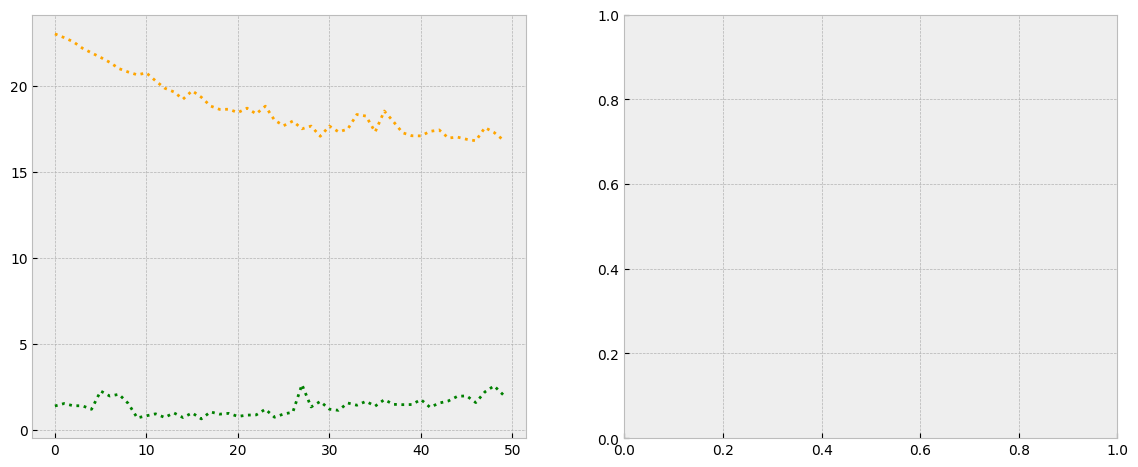

In [80]:
model_an = Sequential()
model_an.add(Dense(50,  activation="relu", input_shape=(features_train_transf.shape[1],)))#activation='sigmoid',
#model_an.add(Dense(500, activation = 'relu'))
model_an.add(Dense(20, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(15, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(10, activation = 'relu'))
#model_an.add(Dropout(rate=0.3))
model_an.add(Dense(1))#,activation = none))

model_an.compile(loss = tf.keras.losses.mse,
                optimizer = 'adam',
                #metrics = ["mae"]
                )  # compile the model

#early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 2)
hist = model_an.fit(features_train_transf, 
                    target_train, 
                    validation_data=(features_test_transf, target_test),
                    epochs=50, 
                    batch_size=1,
                    #callbacks=[early_stop]
                   )#fits the model
# batch_size: 32 bis 512, also 32, 64, 128, 256, 512


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5.5))
l = len(hist.history['loss'])
ax[0].plot(range(l), hist.history['loss'],linestyle=':', color = 'orange')
ax[0].plot(range(l), hist.history['val_loss'],linestyle=':', color = 'green')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MSE on Train set:  16.01683013480674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MSE on Test set:  2.020639886136939


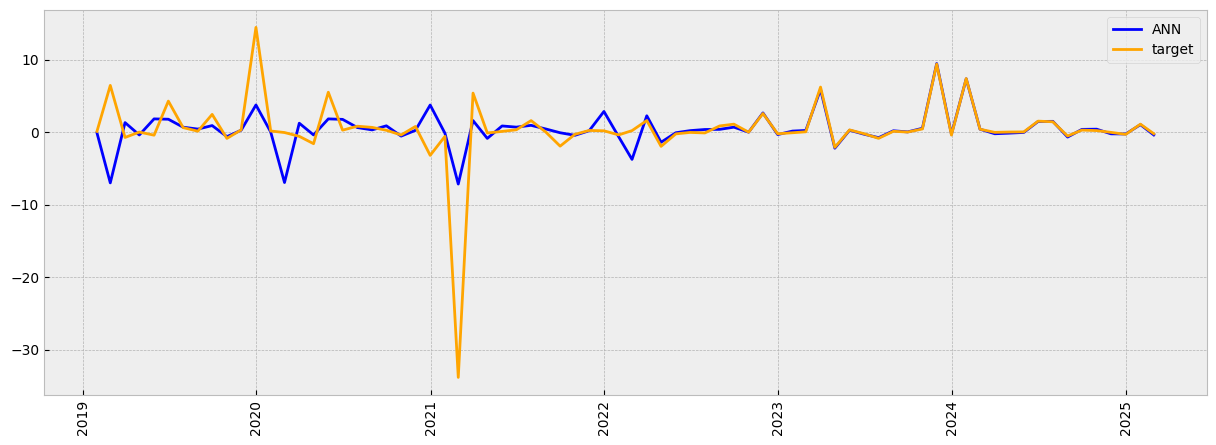

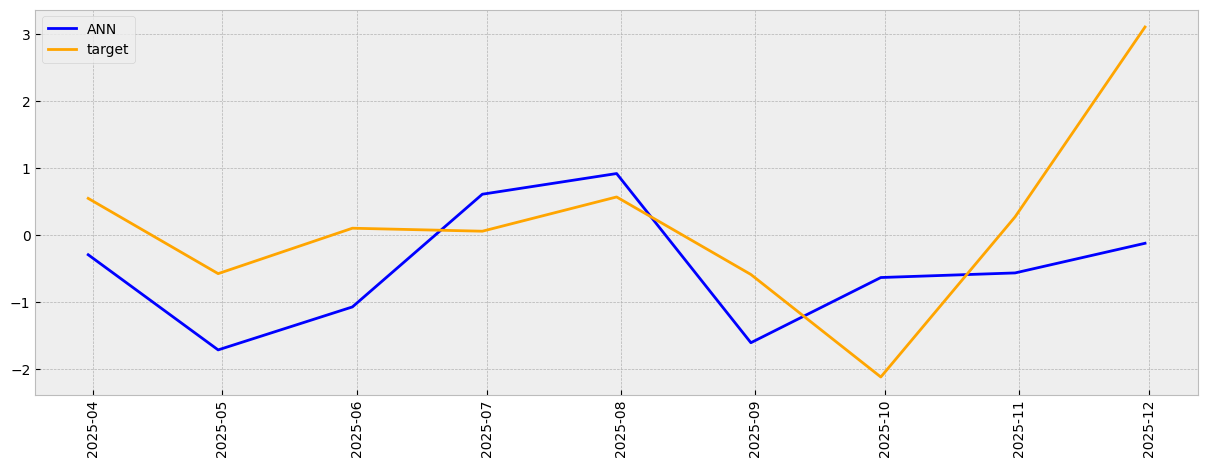

In [81]:

results = model_an.predict(features_train_transf)
print('MSE on Train set: ', mean_squared_error(results, target_train))
#results['target']=target_train
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.plot(target_train.index,results, label = 'ANN', color = 'blue');
ax.plot(target_train.index, target_train,  label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax.legend()
# Predict testdata 
results_test = model_an.predict(features_test_transf)
#results_test['target']=target_test
print('MSE on Test set: ', mean_squared_error(results_test, target_test))
fig_test, ax_test = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax_test.plot(target_test.index,results_test, label = 'ANN', color = 'blue');
ax_test.plot(target_test.index,target_test, label = 'target', color = 'orange');
plt.xticks(rotation=90)
ax_test.legend()

### ARIMAX

In [139]:
data = df.loc[:,'elasticity_coffee']
#data = data.asfreq('MS')
#data = data['litters']

In [140]:
data

date
2019-01-31    0.092550
2019-02-28    6.430267
2019-03-31   -0.744450
2019-04-30   -0.002626
2019-05-31   -0.432072
                ...   
2025-07-31    0.563849
2025-08-31   -0.593607
2025-09-30   -2.124554
2025-10-31    0.266662
2025-11-30    3.101441
Name: elasticity_coffee, Length: 83, dtype: float64

In [141]:
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Train dates : 2019-01-31 00:00:00 --- 2025-03-31 00:00:00  (n=75)
Test dates  : 2025-03-31 00:00:00 --- 2025-11-30 00:00:00  (n=9)


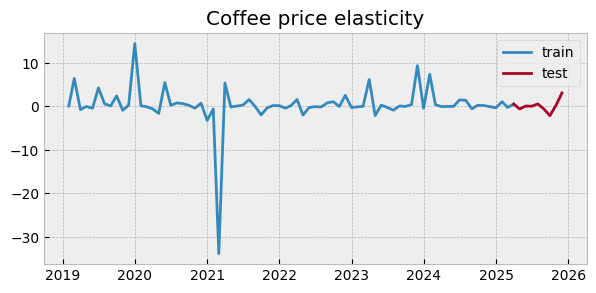

In [142]:
# Train-test dates
# ==============================================================================
end_train = '2025-03-31'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ==============================================================================
#set_dark_theme()
fig, ax=plt.subplots(figsize=(7, 3))
ax.plot(data_train, label='train')
ax.plot(data_test, label='test')
ax.set_title('Coffee price elasticity')
ax.legend();

Test stationarity for original series
-------------------------------------
ADF Statistic: -9.978519985288937, p-value: 2.145410041713563e-17
KPSS Statistic: 0.10312428224040007, p-value: 0.1

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -6.983036658325007, p-value: 8.099705336866723e-10
KPSS Statistic: 0.11469174010081847, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -5.707002876207295, p-value: 7.448377463557587e-07
KPSS Statistic: 0.09960212899320262, p-value: 0.1


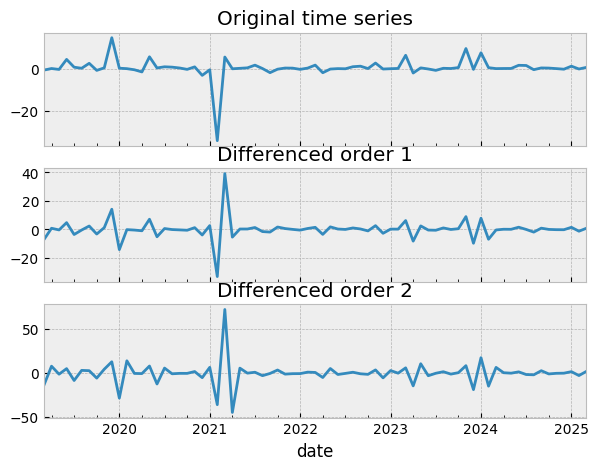

In [143]:
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

# Suppress warnings for stationarity tests
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    print('Test stationarity for original series')
    print('-------------------------------------')
    adfuller_result = adfuller(data)
    kpss_result = kpss(data)
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

    print('\nTest stationarity for differenced series (order=1)')
    print('--------------------------------------------------')
    adfuller_result = adfuller(data_diff_1)
    kpss_result = kpss(data.diff().dropna())
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

    print('\nTest stationarity for differenced series (order=2)')
    print('--------------------------------------------------')
    adfuller_result = adfuller(data_diff_2)
    kpss_result = kpss(data.diff().diff().dropna())
    print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
data.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

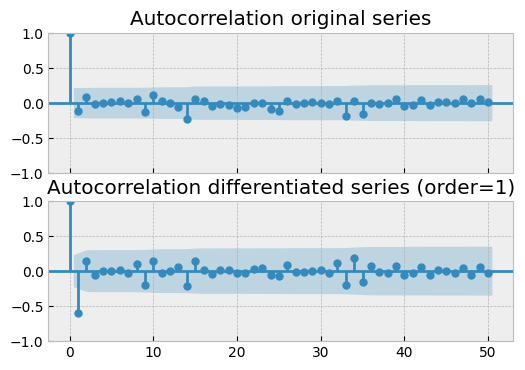

In [144]:
# Autocorrelation plot for original and differentiated series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(data, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differentiated series (order=1)');

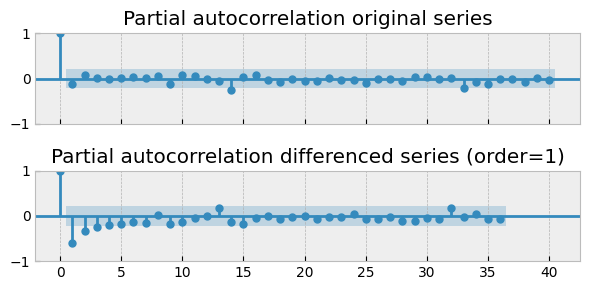

In [145]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(data, ax=axs[0], lags=40, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=36, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

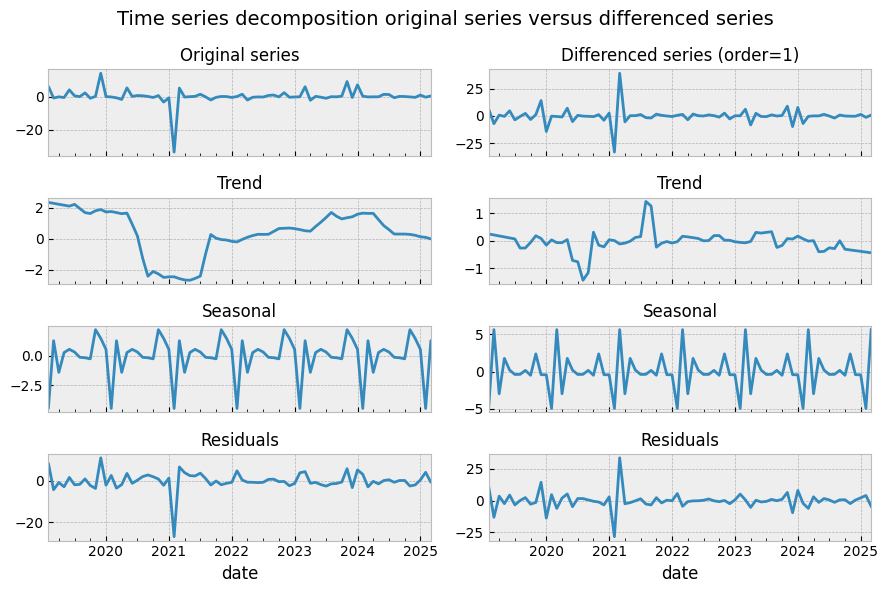

In [146]:
# Time series decomposition of original versus differenced series
# ==============================================================================
res_decompose = seasonal_decompose(data, model='additive', extrapolate_trend='freq', period=12)
res_descompose_diff_2 = seasonal_decompose(data_diff_1, model='additive', extrapolate_trend='freq', period=12)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)

res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced series (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonal', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals', fontsize=12)
fig.suptitle('Time series decomposition original series versus differenced series', fontsize=14)
fig.tight_layout();

In [147]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
model_res.summary()

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  elasticity_coffee   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -199.726
Date:                            Tue, 24 Feb 2026   AIC                            409.452
Time:                                    09:34:09   BIC                            420.088
Sample:                                01-31-2019   HQIC                           413.628
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1583      0.115     -1.382      0.167      -0.383       0.066
ma.L1         -0.8701      0.109     -7.984      0.000      -1.084      -0.657
ar.S.L12       0.0330      0.179      0.184      0.854      -0.319       0.385
ma.S.L12      -0.9989    101.379     -0.010      0.992    -199.699     197.701
sigma2        25.3463   2566.211      0.010      0.992   -5004.335    5055.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               407.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
# Prediction
# ==============================================================================
predictions_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predictions_statsmodels.name = 'predictions_statsmodels'
predictions_statsmodels.index

DatetimeIndex(['2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31',
               '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30',
               '2025-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [149]:
# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme, plot_prediction_intervals
from skforecast.stats import Sarimax, Arima
from skforecast.recursive import ForecasterStats
from skforecast.utils import expand_index
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, grid_search_stats


In [150]:
# ARIMA model with skforecast Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model.fit(y=data_train)
model.summary()

c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                  elasticity_coffee   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -199.726
Date:                            Tue, 24 Feb 2026   AIC                            409.452
Time:                                    09:34:19   BIC                            420.088
Sample:                                01-31-2019   HQIC                           413.628
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1583      0.115     -1.382      0.167      -0.383       0.066
ma.L1         -0.8701      0.109     -7.984      0.000      -1.084      -0.657
ar.S.L12       0.0330      0.179      0.184      0.854      -0.319       0.385
ma.S.L12      -0.9989    101.379     -0.010      0.992    -199.699     197.701
sigma2        25.3463   2566.211      0.010      0.992   -5004.335    5055.027
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               407.00
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [151]:
# Prediction
# ==============================================================================
predictions_skforecast_sarimax = model.predict(steps=len(data_test))
predictions_skforecast_sarimax = pd.DataFrame(predictions_skforecast_sarimax, index=data_test.index)
predictions_skforecast_sarimax.columns = ['skforecast']
display(predictions_skforecast_sarimax.head(4))

,skforecast
date,
2025-03-31,NaN
2025-04-30,-0.779464
2025-05-31,0.741917
2025-06-30,0.998639


In [152]:
# ARIMA model with skforecast Arima
# ==============================================================================
model = Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12)
model.fit(y=data_train, suppress_warnings=True)
model.summary()

ARIMA Model Summary
Model     : Arima(1,1,1)(1,1,1)[12]
Method    : ARIMA(1,1,1)(1,1,1)[12]
Converged : False

Coefficients:
------------------------------------------------------------
  ar1            :    -0.5291  (SE:   0.2496, t:    -2.12)
  ma1            :    -0.6956  (SE:   0.2427, t:    -2.87)
  sar1           :    -0.1254  (SE:      nan, t:      nan)
  sma1           :    -0.3759  (SE:      nan, t:      nan)

Model fit statistics:
  sigma^2:             41.835945
  Log-likelihood:      -206.63
  AIC:                 423.26
  BIC:                 N/A

Residual statistics:
  Mean:                0.279552
  Std Dev:             5.913758
  MAE:                 3.330437
  RMSE:                5.880849

Time Series Summary Statistics:
Number of observations: 75
  Mean:                 0.3683
  Std Dev:              4.7910
  Min:                  -33.8220
  25%:                  -0.2464
  Median:               0.0926
  75%:                  0.7058
  Max:                  14.4284


c:\Users\judit\Portfolioprojekte\dpp_projekt_2026\.venv\Lib\site-packages\skforecast\stats\_arima.py:1065: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(self.var_coef_[i, i])


In [153]:
# Prediction
# ==============================================================================
predictions_skforecast_arima = model.predict(steps=len(data_test))
#pred_index = expand_index(index=data_train.index, steps=len(data_test))
predictions_skforecast_arima = pd.Series(predictions_skforecast_arima, index=data_test.index)
predictions_skforecast_arima.head(4)


date
2025-03-31   -1.452699
2025-04-30   -1.022238
2025-05-31   -0.113180
2025-06-30   -0.520082
dtype: float64

In [160]:
.index

SyntaxError: invalid syntax (3312948729.py, line 1)

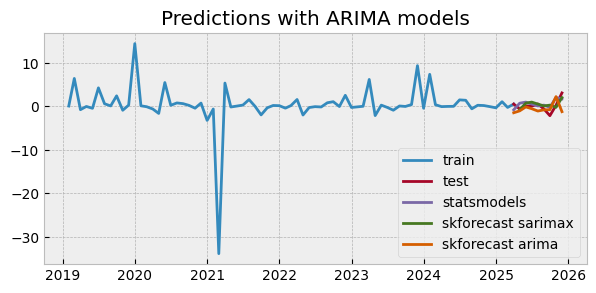

In [154]:


# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data_train, label='train')
ax.plot(data_test, label='test')
ax.plot(predictions_skforecast_sarimax.index, predictions_statsmodels.values, label='statsmodels')
ax.plot(predictions_skforecast_sarimax, label='skforecast sarimax')
ax.plot(predictions_skforecast_arima, label='skforecast arima')
ax.set_title('Predictions with ARIMA models')
ax.legend();
